In [43]:
%reload_ext autoreload
%autoreload 2

In [44]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import IFrame, clear_output

In [45]:
#!pip install xgboost
#!pip install lightgbm
#!pip install catboost
#!pip install scikit-optimize
#!pip install pickle
#!pip install shap

clear_output()

In [46]:
import os
import time
import logging
from functools import wraps
import pickle
import re
import glob2

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

from numpy import hstack

from IPython.display import IFrame
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

from plot_utils import *

In [47]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler

from sklearn.feature_selection import SelectKBest, f_classif, chi2, mutual_info_classif
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, plot_confusion_matrix, ConfusionMatrixDisplay, classification_report

from sklearn.utils import shuffle
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score

In [6]:
logger = logging.getLogger(__name__)
logger.setLevel("INFO")
handler = logging.StreamHandler()
logger.addHandler(handler)
#https://gist.github.com/bradmontgomery/bd6288f09a24c06746bbe54afe4b8a82

def timed(func):
    """This decorator prints the execution time for the decorated function."""

    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        logger.info("EXECUTION TIME : {} ran in {}s".format(func.__name__, round(end - start, 2)))
        return result

    return wrapper


def pickle_results(results, file, path='nested-cv-results'):
    file_path = os.path.join(path, file)
    pickle.dump(results, open( file_path, "wb" ), protocol=pickle.HIGHEST_PROTOCOL)
    
def unpickle_results(file, path='nested-cv-results'):
    file_path = os.path.join(path, file)
    return pickle.load(open( file_path, "rb" ))

In [7]:
def get_data(folder_path, file_name, index_value = 'md5'):
    df = pd.read_csv(os.path.join(folder_path, file_name), index_col=index_value)
    return df

def print_proportion(df, label = 'label'):
    print('Proportion : {:.2f}%'.format(100*sum(df.label)/len(df)))

def create_X_y(folder_path, file_name, drop_null_columns=False, index_value = 'md5'):
    file_path = os.path.join(folder_path, file_name)
    df = pd.read_csv(file_path, index_col = index_value)
    X = df.drop('label', axis=1)
    #X = df.drop(['label', 'sublabel'], axis=1)
    if drop_null_columns == True:
        X = X.drop(get_null_columns(X), axis=1)
    y = df['label']
    return shuffle(X, y)

def create_X_y_(df, drop_null_columns=False, index_value = 'md5'):
    X = df.drop('label', axis=1)
    #X = df.drop(['label', 'sublabel'], axis=1)
    if drop_null_columns == True:
        X = X.drop(get_null_columns(X), axis=1)
    y = df['label']
    return shuffle(X, y)

def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=2)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    return scores

def k_best_selection_(X, y, select_function=f_classif, k=10):
    selector = SelectKBest(select_function, k=k).fit(X, y)
    selected_columns_indices = selector.get_support(indices=True)
    selected_df = X.iloc[:,selected_columns_indices]
    selected_columns = selected_df.columns.tolist()
    return selected_columns

In [8]:
@timed
def hyperparameter_tuning(X_train, y_train, model, tuning_params, scoring='accuracy', cv_strategy=None, n_iterations = 25, verbose=True, folder_name='default', best_model=False):

    bsearch = BayesSearchCV(estimator = model,
                            search_spaces = tuning_params,                        
                            scoring = scoring,
                            cv = cv_strategy,
                            n_jobs = -1,
                            verbose = 0,
                            random_state = 1,
                            n_iter = n_iterations)
    
    
    def status_print(optim_result):
        """Status callback durring bayesian hyperparameter search"""

        # Get all the models tested so far in DataFrame format
        all_models = pd.DataFrame(bsearch.cv_results_)    

        # Get current parameters and the best parameters    
        best_params = pd.Series(bsearch.best_params_)
        if verbose == True:
                print('Model #{}\nBest {}: {}\nBest params: {}\n'.format(
                len(all_models),
                scoring.upper(),
                np.round(bsearch.best_score_, 4),
                bsearch.best_params_
                ))

        # Save all model results
        clf_name = bsearch.estimator.__class__.__name__
        folder_path = os.path.join("bayes-search-models", folder_name)
        all_models.to_csv(os.path.join(folder_path, clf_name+"_cv_results.csv"))
   
    bsearch.fit(X_train,y_train, callback=status_print)

    result = bsearch.best_params_
    
    if best_model == True:
        result = bsearch.best_params_, bsearch.best_estimator_
    
    return result

In [114]:
def score_model_dataset(df, model, execution_time=False, label='label'):
    X, y = get_X_y(df, label=label)
    start = time.time()
    scores = evaluate_model(model, X, y)
    result = scores
    if execution_time == True:
        duration = time.time() - start
        result = scores, duration
    return result


def join_dfs(dfs, labels=['label'], initialization=None):
    if initialization is None:
        sorted_dfs = sorted(dfs, key=lambda df:len(df), reverse=True)
        initialization = sorted_dfs[0][labels[0]]
    joined = pd.DataFrame(initialization)
    for df in dfs:
        joined = joined.join(df.drop(labels, axis=1)).fillna(0)
    return joined


def retrieve_subset(original_df, X, y = None, label='label', features_only=False):
    filtered_columns = original_df.columns.tolist()
    filtered_columns.remove(label)
    if features_only == False :
        filtered_index = original_df.index.intersection(X.index)
        X_new = X.loc[filtered_index, filtered_columns]
        y_new = y.loc[filtered_index]
        return X_new, y_new
    else :
        X_new = X.loc[:, filtered_columns]
        return X_new
    
    
def prepare_training_datasets(original_dfs, X_train_full, X_test, y_train_full, y_test, test_size = 0.4, label='label'):
    datasets = []
    X_train, X_eval, y_train, y_eval = train_test_split(X_train_full, y_train_full, test_size = test_size, random_state = 1)
    for df in original_dfs:
        dataset = dict()
        dataset['train'] = retrieve_subset(df, X_train, y_train, label=label)
        dataset['eval'] = ( retrieve_subset(df, X_eval, features_only=True, label=label), y_eval )
        dataset['test'] = ( retrieve_subset(df, X_test, features_only=True, label=label), y_test )
        datasets.append(dataset)
    return datasets
    
    
def fit_ensemble(models, datasets):
    X_meta = list()
    for model, dataset in zip(models, datasets):
        model.fit(*dataset['train'])
        y_pred = model.predict(dataset['eval'][0])
        y_pred = y_pred.reshape(len(y_pred), 1)
        X_meta.append(y_pred)
    X_meta = np.hstack(X_meta)
    blender = LogisticRegression()
    blender.fit(X_meta, dataset['eval'][1])
    return blender


def predict_ensemble(models, blender, datasets):
    X_meta = list()
    for model, dataset in zip(models, datasets):
        y_pred = model.predict(dataset['test'][0])
        y_pred = y_pred.reshape(len(y_pred), 1)
        X_meta.append(y_pred)
    X_meta = np.hstack(X_meta)
    return blender.predict(X_meta)


def get_blender_accuracy(original_dfs, X_train_full, X_test, y_train_full, y_test, models, label='label'):
    datasets = prepare_training_datasets(original_dfs, X_train_full, X_test, y_train_full, y_test, test_size = 0.4, label=label)
    blender = fit_ensemble(models, datasets)
    y_pred = predict_ensemble(models, blender, datasets)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

In [11]:
def get_ensemble_models_():
    models = dict()
    models['RF'] = RandomForestClassifier()
    models['ExRF'] = ExtraTreesClassifier()
    models['AdaBoost'] = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2), n_estimators=500)
    models['GB'] = GradientBoostingClassifier()
    models['XGBoost'] = XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', silent=1, tree_method='approx')
    models['LightGBM'] = LGBMClassifier(objective='binary', metric='binary_logloss', verbose=0)
    #models['CatBoost'] = CatBoostClassifier(thread_count=2, loss_function='Logloss', od_type = 'Iter', verbose= False)
    return models

In [12]:
def get_pipeline_(clf, scaler=StandardScaler()):
    return Pipeline(steps=[('scaler', scaler), ('clf', clf)])
    
def get_pipeline(clf, scaler=None, selector=None):
    steps = []
    if scaler is not None:
        steps.append(('scaler', scaler))
    if selector is not None:
        steps.append(('selector', selector))
    steps.append(('clf', clf))
    return Pipeline(steps=steps)
    
def print_mean_std(scores, model_name, execution_time=None):
    if execution_time is not None:
        print(f'{model_name:<14}: {round(100*np.mean(scores), 2)}% ( +/- {round(100*np.std(scores), 2)}% ) -- [ {round(execution_time, 2)}s ]')
    else:
        print(f'{model_name:<14}: {round(100*np.mean(scores), 2)}% ( +/- {round(100*np.std(scores), 2)}% )')

In [13]:
def clean_column_names(df):
    '''replace the characters ( '[', ']', '<' ) with ( '_' ) in column names because XGBoost doesnt accept them'''
    df = df.copy()
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
    #df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
    return df

def change_column_names(df, label = 'label'):
    '''replace all column names apart from target'''
    df = df.copy()
    columns_ = df.columns.tolist()
    columns_.remove(label)
    new_columns = ['feature' + str(i) for i in range(len(columns_))]
    mapper = {key: value for (key,value) in zip(columns_, new_columns)}
    df = df.rename(columns = mapper)
    return df

## JOINED DATA

In [61]:
from helpers import *
from learners import *

In [62]:
def prepare_datasets(datasets_path='datasets', columns_path=None, label='sublabel', verbose=True, prefix=True):
    
    datasets = dict()
    
    #retrieve list of files
    datasets_files = get_file_list(datasets_path, extensions=['gz'])
    columns_files = get_file_list(columns_path, extensions=['pkl'])
    
    for file in datasets_files:
        
        #retrieve name corresponding to selected features file and define the full path 
        basename = os.path.splitext(os.path.basename(file))[0]
        if columns_path is not None:
            columns_file = os.path.join(columns_path, basename)
        
        #print current processed dataset
        if verbose:
            print(basename.split('.')[0])
            
        #load full dataset    
        dataset = get_data(file_path = file, compression='gzip', verbose=verbose)
        
        #subset dataset with selected features
        if len(columns_files) > 0:
            if columns_file in columns_files:
                columns = unpickle_results(columns_file)
                dataset = dataset[list(columns)+[label]]
                
                #prefix column names to avoid column names overlap
                if prefix:
                    mapping = { column : basename.split('.')[0] + '_' + column for column in columns }
                    dataset.rename(columns = mapping, inplace=True)            
            #print resulted shape
            if verbose:
                print('resulted data shape :'.ljust(20), dataset.shape, '\n')
            
        #append datasets    
        datasets[basename.split('.')[0]] = dataset
        
    datasets['regkeys_summary'].drop(columns=['label'], inplace=True)
    datasets['fileops_summary'].drop(columns=['label'], inplace=True)
        
    return datasets

## Data Loading

Loading the datasets and retrieving the subsets with previously selected variables:

In [63]:
folder_path = 'datasets/ransomware'
columns_path = 'selected-features/ransomware/unprefixed'
datasets = prepare_datasets(datasets_path=folder_path, columns_path=columns_path, label='sublabel', verbose=True, prefix=True)

apistats_counts
loaded data shape :   (2618, 301)
resulted data shape : (2618, 251) 

fileops_created_nested_files
loaded data shape :   (1232, 9747)
resulted data shape : (1232, 301) 

fileops_deleted_nested_files
loaded data shape :   (1029, 5537)
resulted data shape : (1029, 201) 

fileops_exists_nested_files
loaded data shape :   (1545, 6847)
resulted data shape : (1545, 101) 

fileops_failed_nested_files
loaded data shape :   (1300, 3073)
resulted data shape : (1300, 101) 

fileops_opened_nested_files
loaded data shape :   (2094, 12066)
resulted data shape : (2094, 501) 

fileops_read_nested_files
loaded data shape :   (1508, 10430)
resulted data shape : (1508, 101) 

fileops_recreated_nested_files
loaded data shape :   (539, 445)
resulted data shape : (539, 51) 

fileops_summary
loaded data shape :   (2392, 12)
resulted data shape : (2392, 12) 

fileops_written_nested_files
loaded data shape :   (1265, 9891)
resulted data shape : (1265, 301) 

loaded_dll_onehot
loaded data shape 

**Summary** of the performance on each dataset using an Extreme Random Forest model:

In [108]:
# initialize a df base containing all samples indices
sorted_dfs = sorted(list(datasets.values()), key=lambda df:len(df), reverse=True)
initialization = sorted_dfs[0]['sublabel']

#initialize a dictionary for saving cross-validation scores
all_scores = { name : [] for name in datasets.keys() }

#initialize a dataframe for saving summary results
results_df = pd.DataFrame('', index=list(datasets.keys()), columns=['median', 'std'])

#specify labels to drop
labels=['sublabel']

for name, dataset in datasets.items():
    
    joined = pd.DataFrame(initialization).join(dataset.drop(labels, axis=1)).fillna(0)

    X, y = get_X_y(joined, label='sublabel')
    steps = smote(X, y, category ='adaptive', over_strategy=0.5, under_strategy=0.8, k_neighbors=5, fit=False)
    steps.append(('preprocessor', MinMaxScaler()))
    steps.append(('classifier', ExtraTreesClassifier()))
    pipe = Pipeline(steps=steps)

    scores = score_model_dataset(joined, model=pipe, label='sublabel')
    
    all_scores[name] = scores
    
    results_df.at[name,'median'] = str(round(100*np.median(scores), 2)) + ' %'
    results_df.at[name,'std'] = str(round(100*np.std(scores), 2)) + ' %'
    
results_df.head()

,median,std
apistats_counts,83.99 %,3.01 %
fileops_created_nested_files,93.79 %,0.88 %
fileops_deleted_nested_files,93.44 %,0.91 %
fileops_exists_nested_files,55.56 %,2.52 %
fileops_failed_nested_files,93.62 %,1.24 %


In [109]:
#make copy
results_df_ = results_df.copy()

#retrieve shapes of initial datasets
#initial_datasets = prepare_datasets(datasets_path=folder_path)

# add datasets shapes
for name, dataset in datasets.items():
    results_df_.at[name,'selected_features'] = int(dataset.shape[1])
for name, dataset in initial_datasets.items():
    results_df_.at[name,'initial_features'] = int(dataset.shape[1])

results_df_[['initial_features', 'selected_features']] = results_df_[['initial_features', 'selected_features']].astype(int)    
results_df_ = results_df_[['initial_features', 'selected_features', 'median', 'std']]

In [119]:
results_df_.to_excel('summary/performance_individual_datasets_ransomware_vs_malware_ExRF.xlsx')

In [110]:
results_df_

,initial_features,selected_features,median,std
apistats_counts,301,251,83.99 %,3.01 %
fileops_created_nested_files,9747,301,93.79 %,0.88 %
fileops_deleted_nested_files,5537,201,93.44 %,0.91 %
fileops_exists_nested_files,6847,101,55.56 %,2.52 %
fileops_failed_nested_files,3073,101,93.62 %,1.24 %
fileops_opened_nested_files,12066,501,97.39 %,0.9 %
fileops_read_nested_files,10430,101,54.01 %,9.9 %
fileops_recreated_nested_files,445,51,85.62 %,0.65 %
fileops_summary,11,11,94.27 %,1.04 %
fileops_written_nested_files,9891,301,93.45 %,0.91 %


## Joining vs. Blending

In [112]:
def get_smoter_pipeline(df):
    X, y = get_X_y(df, label='sublabel')
    steps = smote(X, y, category ='adaptive', over_strategy=0.5, under_strategy=0.8, k_neighbors=5, fit=False)
    steps.append(('preprocessor', MinMaxScaler()))
    steps.append(('classifier', ExtraTreesClassifier()))
    pipe = Pipeline(steps=steps)
    return pipe

In [105]:
#retrieve the datasets contributing the most
highest_accuracy_datasets = [
    'apistats_counts',
    'fileops_opened_nested_files',
    'fileops_summary',
    'pe_entropy_analysis',
    'pe_imports_libraries',
    'regkeys_written_nested_keys',
    'regkeys_summary',
]

#initialize a df base containing all samples indices
sorted_dfs = sorted(list(datasets.values()), key=lambda df:len(df), reverse=True)
initialization = sorted_dfs[0]['sublabel']

In [107]:
#compute joining datasets score
joined_df = join_dfs(dfs = [datasets[column] for column in highest_accuracy_datasets],
                     labels = ['sublabel'],
                     initialization = initialization)

pipe = get_smoter_pipeline(joined_df)

joining_scores = score_model_dataset(joined_df, model=pipe, execution_time=False, label='sublabel')

In [115]:
#compute blending datasets scores
CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

models = [get_smoter_pipeline(joined_df) for i in range(len(highest_accuracy_datasets))]

blending_scores = []

original_dfs = [datasets[name] for name in highest_accuracy_datasets]

X, y = get_X_y(joined_df, label='sublabel')

for train_index, test_index in CV.split(X, y):
    X_train_full, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_full, y_test = y[train_index], y[test_index]
    score = get_blender_accuracy(original_dfs, X_train_full, X_test, y_train_full, y_test, models, label='sublabel')
    blending_scores.append(score)

In [116]:
scores_list = [ scores for name, scores in all_scores.items() if name in highest_accuracy_datasets]
names_list = [ name for name in highest_accuracy_datasets ]

scores_list.append(joining_scores)
scores_list.append(blending_scores)

names_list.append('joining')
names_list.append('blending')

In [118]:
fig = plot_evaluation_boxplots(scores_list, 
                               names = names_list, 
                               title = 'Model Performance on joined and blended Data', 
                               y_axis = 'Accuracy')

figure_path = 'figures/joining-strategy/evaluation_joining_vs_blending_ransomware.html'

save_figures_to_html(figure_path, [fig])

IFrame(figure_path, width=900, height=600)

# Final model training :

**Hyperparameter Tunning :**

In [9]:
import sklearn

sklearn. __version__

'0.23.2'

In [10]:
cv_strategy = StratifiedKFold( n_splits=5, shuffle=True, random_state=2 )

#hyperparameter tuning grid
xgb_grid_params = {
        'selector__k' : Integer(100, 1000),
        'clf__n_estimators': Integer(50, 200),
        'clf__learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'clf__min_child_weight': Integer(0, 10),
        'clf__max_depth': Integer(1, 20), #(0,50)
        'clf__subsample': Real(0.5, 1.0, 'uniform'), #(0.01, 1.0, 'uniform')                      
        'clf__colsample_bytree': Real(0.1, 1.0, 'uniform'), #Real(0.01, 1.0, 'uniform') 
        #'gamma': Real(1e-9, 0.5, 'log-uniform'),
        #'lambda': Real(1e-9, 1000, 'log-uniform'),
        #'alpha': Real(1e-9, 1.0, 'log-uniform'),
        #'colsample_bylevel': Real(0.1, 1.0, 'uniform'), #Real(0.01, 1.0, 'uniform')
        #'max_delta_step': Integer(0, 10),  
        #'scale_pos_weight': Real(1e-6, 500, 'log-uniform')
}

#joining all data
joined_df = join_dfs(dfs = [datasets[column] for column in list(datasets.keys())],
                     labels = ['sublabel'])

#cleaning names
joined_df_ = clean_column_names(joined_df)

#defining features and label
X, y = get_X_y(joined_df_, label='sublabel')

#building the pipeline
steps = smote(X, y, category ='adaptive', over_strategy=0.5, under_strategy=0.8, k_neighbors=5, fit=False)

steps.extend([
    ('selector', SelectKBest(chi2, k=50)),
    ('preprocessor', MinMaxScaler()),
    ('clf', XGBClassifier(objective = 'binary:logistic', eval_metric = 'error', silent=1, tree_method='approx'))
])

pipe = Pipeline(steps=steps)

#tuning the model
pipe_best_params = hyperparameter_tuning(X, y, 
                                         model = pipe, 
                                         tuning_params = xgb_grid_params,
                                         scoring = 'accuracy',
                                         cv_strategy = cv_strategy,
                                         n_iterations = 50)

Model #1
Best ACCURACY: 0.9474
Best params: OrderedDict([('clf__colsample_bytree', 0.732380493199923), ('clf__learning_rate', 0.01328322299832468), ('clf__max_depth', 8), ('clf__min_child_weight', 1), ('clf__n_estimators', 124), ('clf__subsample', 0.9444627024858503), ('selector__k', 153)])

Model #2
Best ACCURACY: 0.9493
Best params: OrderedDict([('clf__colsample_bytree', 0.7152016958868623), ('clf__learning_rate', 0.04668884070205238), ('clf__max_depth', 2), ('clf__min_child_weight', 4), ('clf__n_estimators', 111), ('clf__subsample', 0.8732189423619144), ('selector__k', 140)])

Model #3
Best ACCURACY: 0.9751
Best params: OrderedDict([('clf__colsample_bytree', 0.847359110986559), ('clf__learning_rate', 0.010638933664917376), ('clf__max_depth', 16), ('clf__min_child_weight', 3), ('clf__n_estimators', 117), ('clf__subsample', 0.8448838230599922), ('selector__k', 718)])

Model #4
Best ACCURACY: 0.9853
Best params: OrderedDict([('clf__colsample_bytree', 0.7330960376694159), ('clf__learnin

Model #30
Best ACCURACY: 0.9876
Best params: OrderedDict([('clf__colsample_bytree', 0.6157646910313589), ('clf__learning_rate', 0.046780711072581665), ('clf__max_depth', 11), ('clf__min_child_weight', 5), ('clf__n_estimators', 63), ('clf__subsample', 1.0), ('selector__k', 1000)])

Model #31
Best ACCURACY: 0.9876
Best params: OrderedDict([('clf__colsample_bytree', 0.6157646910313589), ('clf__learning_rate', 0.046780711072581665), ('clf__max_depth', 11), ('clf__min_child_weight', 5), ('clf__n_estimators', 63), ('clf__subsample', 1.0), ('selector__k', 1000)])

Model #32
Best ACCURACY: 0.9876
Best params: OrderedDict([('clf__colsample_bytree', 0.6157646910313589), ('clf__learning_rate', 0.046780711072581665), ('clf__max_depth', 11), ('clf__min_child_weight', 5), ('clf__n_estimators', 63), ('clf__subsample', 1.0), ('selector__k', 1000)])

Model #33
Best ACCURACY: 0.9876
Best params: OrderedDict([('clf__colsample_bytree', 0.6157646910313589), ('clf__learning_rate', 0.046780711072581665), ('c

EXECUTION TIME : hyperparameter_tuning ran in 1087.97s


In [12]:
#dataset
joined_df = join_dfs(list(datasets.values()), labels=['sublabel'])

#clean column names
joined_df_ = clean_column_names(joined_df)

#define best parameters
clf_params = {
        'n_estimators': 88,
        'learning_rate': 0.16253326217309255,
        'min_child_weight': 5,
        'max_depth': 6, 
        'gamma': 1e-09,
        'subsample': 0.5,              
        'colsample_bytree': 1,      
        'lambda': 1e-09,
        'alpha': 1e-09
}

#define XGBoost model
xgb_model = XGBClassifier(objective = 'binary:logistic', 
                          eval_metric = 'error', 
                          silent=1, 
                          tree_method='approx',
                          **clf_params)


#define pipeline
pipe = Pipeline(steps=[
    ('selector', SelectKBest(chi2, k=1000)),
    ('preprocessor', MinMaxScaler()),
    ('clf', xgb_model)
])

#define Features and label
X, y = get_X_y(joined_df_, label='sublabel')

#perform SMOTE
X, y = smote(X, y, category ='adaptive', over_strategy=0.5, under_strategy=0.8, k_neighbors=5, fit=True)

#train the model
pipe.fit(X, y)

[00:39:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(steps=[('selector',
                 SelectKBest(k=1000,
                             score_func=<function chi2 at 0x00000148382A38B0>)),
                ('preprocessor', MinMaxScaler()),
                ('clf',
                 XGBClassifier(alpha=1e-09, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='error',
                               gamma=1e-09, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', lambda=1e-09,
                               learning_rate=0.16253326217309255,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=88,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=9.99999972e-10,
   

In [13]:
#save model
model_path = 'trained-model/model_ransomware.pkl'
pickle.dump(pipe, open(model_path, 'wb'))

In [14]:
#load and reuse model
model = pickle.load(open(model_path, 'rb'))
model.score(X,y)

0.9959432048681541

In [95]:
#save all feature columns pickled
columns = list(X.columns)
pickle.dump(columns, open('selected-features/ransomware/all_columns.pkl', 'wb'))

### Analyzing the contribution of features:

In [65]:
#dataset
joined_df = join_dfs(list(datasets.values()), labels=['sublabel'])

#clean column names
joined_df_ = clean_column_names(joined_df)

#define best parameters
clf_params = {
        'n_estimators': 88,
        'learning_rate': 0.16253326217309255,
        'min_child_weight': 5,
        'max_depth': 6, 
        'gamma': 1e-09,
        'subsample': 0.5,              
        'colsample_bytree': 1,      
        'lambda': 1e-09,
        'alpha': 1e-09
}

#define XGBoost model
xgb_model = XGBClassifier(objective = 'binary:logistic', 
                          eval_metric = 'error', 
                          silent=1, 
                          tree_method='approx',
                          **clf_params)


#define pipeline
pipe = Pipeline(steps=[
    ('preprocessor', MinMaxScaler()),
    ('clf', xgb_model)
])

#define Features and label
X, y = get_X_y(joined_df_, label='sublabel')

#perform SMOTE
X, y = smote(X, y, category ='adaptive', over_strategy=0.5, under_strategy=0.8, k_neighbors=5, fit=True)

#train the model
pipe.fit(X, y)

[03:19:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(steps=[('preprocessor', MinMaxScaler()),
                ('clf',
                 XGBClassifier(alpha=1e-09, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='error',
                               gamma=1e-09, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', lambda=1e-09,
                               learning_rate=0.16253326217309255,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=5, missing=nan,
                               monotone_constraints='()', n_estimators=88,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=9.99999972e-10,
                               reg_lambda=9.99999972e-10, scale_pos_weight=1,
                               silent=1, subsample=0.5, tree_method='app

In [84]:
def get_fi_columns(X, pipe, limit=None):
    fi = pipe['clf'].feature_importances_
    sorted_fi_idx = np.argsort((-1)*fi)
    if limit is not None:
        sorted_fi_idx = sorted_fi_idx[:limit]
    return X.columns[sorted_fi_idx], fi[sorted_fi_idx]
    
columns, fi = get_fi_columns(X, pipe, limit=None)

**Dataset contribution weights :**

In [85]:
contributions = {key : 0 for key in datasets.keys()}

for key in datasets.keys():
    for column, value in zip(columns, fi):
        if key in column:
            contributions[key] += value

In [86]:
fileops = sum([contributions[key] for key in contributions.keys() if 'fileops' in key])
regkeys = sum([contributions[key] for key in contributions.keys() if 'regkeys' in key])
pe_imports = sum([contributions[key] for key in contributions.keys() if 'pe_imports' in key])

contributions_summary = {
    'api calls' : contributions['apistats_counts'],
    'file operations' : fileops,
    'registry keys' : regkeys,
    'loaded dll' : contributions['loaded_dll_onehot'],
    'pe entropy' : contributions['pe_entropy_analysis'],
    'pe imports' : pe_imports
}

contributions_sum = sum([ value for value in contributions_summary.values() ])

contributions_summary = { key: str(round(100*value/contributions_sum, 2)) + ' %' for key, value in contributions_summary.items()}

In [90]:
pd.json_normalize(contributions_summary).to_excel('summary/dataset_contribution_level_ransomware_vs_malware.xlsx')

**Highest contributing features :**

In [92]:
list(get_fi_columns(X, pipe, limit=30)[0])

['fileops_opened_nested_files_administrator',
 'pe_imports_kernel32_InitializeSListHead',
 'pe_entropy_analysis_.text',
 'apistats_counts_LdrGetProcedureAddress',
 'fileops_opened_nested_files_windows',
 'loaded_dll_onehot_api-ms-win-core-localization-l1-2-1',
 'apistats_counts_NtFreeVirtualMemory',
 'fileops_exists_nested_files_administrator',
 'regkeys_read_nested_keys_pt-br',
 'pe_imports_kernel32_GetModuleHandleExW',
 'pe_entropy_analysis_UPX1',
 'fileops_created_nested_files_administrator',
 'pe_imports_advapi32_RegCloseKey',
 'regkeys_read_nested_keys_currentversion',
 'pe_imports_kernel32_IsProcessorFeaturePresent',
 'loaded_dll_onehot_ntdll',
 'apistats_counts_NtClose',
 'apistats_counts_NtProtectVirtualMemory',
 'regkeys_read_nested_keys_en-us',
 'pe_imports_libraries_msvcrt.dll',
 'fileops_deleted_nested_files_administrator',
 'regkeys_read_nested_keys_nls',
 'pe_imports_libraries_gdi32.dll',
 'fileops_failed_nested_files_administrator',
 'fileops_opened_nested_files_users',


### API Calls

**One-Hot Encoded**

In [12]:
file_name_1 = 'onehot_encoded_apistats_dataset.csv'

oh_apis = get_data(folder_path, file_name_1)

oh_apis.shape

(3761, 304)

In [13]:
print_proportion(oh_apis)

Proportion : 58.23%


In [59]:
#compute api cross-validation accuracy scores
api_scores = score_model_dataset(oh_apis, RandomForestClassifier())
np.mean(api_scores)

EXECUTION TIME : score_model_dataset ran in 10.24s


0.9467353782192374

In [60]:
api_scores_ = score_model_dataset(oh_apis, ExtraTreesClassifier())
np.mean(api_scores_)

EXECUTION TIME : score_model_dataset ran in 12.34s


0.945936800421393

**Count Encoded**

In [48]:
file_name_11 = 'count_encoded_apistats_dataset.csv'

count_apis = get_data(folder_path, file_name_11)

count_apis.shape

(3822, 305)

In [49]:
print_proportion(count_apis)

Proportion : 58.71%


In [69]:
#compute api cross-validation accuracy scores:

print('NO SCALING:\n')
for name, model in get_ensemble_models_().items():
    count_api_scores = score_model_dataset(count_apis, model)
    print_mean_std(count_api_scores, name)
    
print('\nWITH SCALING:\n')
for name, model in get_ensemble_models_().items():
    count_api_scores = score_model_dataset(count_apis, get_pipeline(model))
    print_mean_std(count_api_scores, name)

NO SCALING:

RF            : 95.05% ( +/- 0.88% )
ExRF          : 95.26% ( +/- 0.98% )
AdaBoost      : 93.3% ( +/- 1.39% )
GB            : 92.55% ( +/- 1.48% )
XGBoost       : 95.26% ( +/- 0.88% )
LightGBM      : 95.11% ( +/- 1.19% )
CatBoost      : 94.37% ( +/- 0.79% )

WITH SCALING:

RF            : 95.21% ( +/- 1.21% )
ExRF          : 95.1% ( +/- 1.08% )
AdaBoost      : 93.04% ( +/- 1.0% )
GB            : 92.55% ( +/- 1.08% )
XGBoost       : 95.26% ( +/- 0.94% )
LightGBM      : 94.99% ( +/- 1.33% )
CatBoost      : 94.37% ( +/- 1.01% )


**Variable selection**

**One-Hot** Encoded API calls

In [95]:
for selector_func in [f_classif, chi2, mutual_info_classif]:
    print(f'\nNO SCALING, WITH VARIABLE SELECTION ({selector_func.__name__} and k=150):\n')
    for name, model in get_ensemble_models_().items():
        api_scores, execution_time = score_model_dataset(oh_apis, 
                                                         get_pipeline(model, selector=SelectKBest(selector_func, k=150)),
                                                         execution_time=True)
        print_mean_std(api_scores, name, execution_time)


NO SCALING, WITH VARIABLE SELECTION (f_classif and k=150):

RF            : 94.35% ( +/- 1.21% ) -- [ 7.89s ]
ExRF          : 94.29% ( +/- 1.09% ) -- [ 8.94s ]
AdaBoost      : 92.0% ( +/- 1.46% ) -- [ 13.95s ]
GB            : 90.99% ( +/- 1.37% ) -- [ 18.51s ]
XGBoost       : 93.63% ( +/- 1.37% ) -- [ 49.35s ]
LightGBM      : 93.84% ( +/- 1.45% ) -- [ 10.21s ]

NO SCALING, WITH VARIABLE SELECTION (chi2 and k=150):

RF            : 90.34% ( +/- 1.2% ) -- [ 8.38s ]
ExRF          : 90.22% ( +/- 1.53% ) -- [ 9.02s ]
AdaBoost      : 88.2% ( +/- 1.67% ) -- [ 12.69s ]
GB            : 87.14% ( +/- 2.12% ) -- [ 18.1s ]
XGBoost       : 89.74% ( +/- 1.42% ) -- [ 46.57s ]
LightGBM      : 89.81% ( +/- 1.71% ) -- [ 9.21s ]

NO SCALING, WITH VARIABLE SELECTION (mutual_info_classif and k=150):

RF            : 93.98% ( +/- 1.25% ) -- [ 138.5s ]
ExRF          : 93.8% ( +/- 1.36% ) -- [ 137.52s ]
AdaBoost      : 91.88% ( +/- 1.39% ) -- [ 147.68s ]
GB            : 90.14% ( +/- 1.36% ) -- [ 154.17s ]
XGB

**Count** Encoded API calls

In [94]:
for selector_func in [f_classif, chi2, mutual_info_classif]:
    print(f'\nNO SCALING, WITH VARIABLE SELECTION ({selector_func.__name__} and k=150):\n')
    for name, model in get_ensemble_models_().items():
        count_api_scores, execution_time = score_model_dataset(count_apis, 
                                                               get_pipeline(model, selector=SelectKBest(selector_func, k=150)),
                                                               execution_time=True)
        print_mean_std(count_api_scores, name, execution_time)


NO SCALING, WITH VARIABLE SELECTION (f_classif and k=150):

RF            : 94.74% ( +/- 1.06% ) -- [ 5.78s ]
ExRF          : 94.67% ( +/- 1.09% ) -- [ 9.92s ]
AdaBoost      : 92.3% ( +/- 1.57% ) -- [ 21.29s ]
GB            : 91.85% ( +/- 1.07% ) -- [ 34.46s ]
XGBoost       : 94.68% ( +/- 0.96% ) -- [ 50.68s ]
LightGBM      : 94.69% ( +/- 0.86% ) -- [ 14.55s ]

NO SCALING, WITH VARIABLE SELECTION (chi2 and k=150):

RF            : 94.65% ( +/- 0.99% ) -- [ 11.15s ]
ExRF          : 94.81% ( +/- 0.81% ) -- [ 15.02s ]
AdaBoost      : 92.67% ( +/- 1.11% ) -- [ 24.4s ]
GB            : 92.41% ( +/- 1.1% ) -- [ 35.03s ]
XGBoost       : 94.82% ( +/- 0.98% ) -- [ 43.45s ]
LightGBM      : 94.9% ( +/- 0.94% ) -- [ 15.6s ]

NO SCALING, WITH VARIABLE SELECTION (mutual_info_classif and k=150):

RF            : 94.98% ( +/- 1.21% ) -- [ 120.04s ]
ExRF          : 95.02% ( +/- 1.07% ) -- [ 121.16s ]
AdaBoost      : 93.16% ( +/- 1.23% ) -- [ 136.3s ]
GB            : 92.5% ( +/- 1.33% ) -- [ 147.25s ]
X

In [98]:
#For prior evaluation of the performance on variable selected data, we'll test the configutation (mutual_info_classif, k=150)
X, y = create_X_y_(count_apis)
count_api_150_best_cols = k_best_selection_(X, y, mutual_info_classif, k=150)

### DLL

In [14]:
file_name_2 = 'onehot_encoded_dll_dataset.csv'

dll_loaded = get_data(folder_path, file_name_2)

dll_loaded.shape

(3162, 2242)

In [15]:
print_proportion(dll_loaded)

Proportion : 58.82%


In [30]:
#compute dll cross-validation accuracy scores
dll_scores = score_model_dataset(dll_loaded, RandomForestClassifier())
np.mean(dll_scores)

EXECUTION TIME : score_model_dataset ran in 15.37s


0.8678043764724672

In [35]:
#XGBoost doesnt accept some characters in column names
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

dll_loaded.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in dll_loaded.columns.values]

#compute dll cross-validation accuracy scores
dll_scores_ = score_model_dataset(dll_loaded, XGBClassifier())
np.mean(dll_scores_)

EXECUTION TIME : score_model_dataset ran in 167.58s


0.878773842324535

**Variable Selection**

In [64]:
for selector_func in [f_classif, chi2, mutual_info_classif]:
    pipe = Pipeline(steps=[('selector', SelectKBest(selector_func, k=150)), ('clf', RandomForestClassifier())])
    dll_selected_scores = score_model_dataset(dll_loaded, pipe)
    print(f'{selector_func.__name__} : {np.mean(dll_selected_scores)}')

f_classif : 0.8721312675531421
chi2 : 0.8535685287971355
mutual_info_classif : 0.8377507354017756


In [79]:
for selector_func in [f_classif, chi2]:
    pipe = Pipeline(steps=[('selector', SelectKBest(selector_func, k=230)), ('clf', RandomForestClassifier())])
    dll_selected_scores = score_model_dataset(dll_loaded, pipe)
    print(f'{selector_func.__name__} : {np.mean(dll_selected_scores)}')

f_classif : 0.8752878382515408
chi2 : 0.8733901023572788


In [80]:
X, y = create_X_y_(dll_loaded)
dll_k_best_cols = k_best_selection_(X, y, f_classif, k=230)

### PE Imports

In [60]:
file_name_3 = 'pe_entropy_dataset.csv'

pe_imports_ = get_data(folder_path, file_name_3)

if 'sublabel' in pe_imports.columns.tolist():
    pe_imports_.drop('sublabel', axis=1, inplace=True)

pe_imports.shape

(4308, 795)

In [61]:
print_proportion(pe_imports_)

Proportion : 60.35%


In [65]:
#prepare column names for XGBoost and LightGBM
pe_imports = change_column_names(pe_imports_)

In [51]:
#compute api cross-validation accuracy scores

print('NO SCALING:\n')
for name, model in get_ensemble_models_().items():
    pe_imports_scores, execution_time = score_model_dataset(pe_imports, 
                                                            model, 
                                                            execution_time=True)
    print_mean_std(pe_imports_scores, name, execution_time)
    
print('\nWITH SCALING:\n')
for name, model in get_ensemble_models_().items():
    pe_imports_scores, execution_time = score_model_dataset(pe_imports, 
                                                            get_pipeline(model, scaler=StandardScaler()), 
                                                            execution_time=True)
    print_mean_std(pe_imports_scores, name, execution_time)

NO SCALING:

RF            : 90.62% ( +/- 1.48% ) -- [ 12.02s ]
ExRF          : 90.83% ( +/- 1.32% ) -- [ 15.82s ]
AdaBoost      : 88.08% ( +/- 1.72% ) -- [ 144.12s ]
GB            : 85.06% ( +/- 1.33% ) -- [ 25.5s ]
XGBoost       : 89.33% ( +/- 1.16% ) -- [ 123.85s ]
LightGBM      : 89.29% ( +/- 1.19% ) -- [ 4.06s ]
CatBoost      : 88.55% ( +/- 1.22% ) -- [ 77.71s ]

WITH SCALING:

RF            : 90.3% ( +/- 1.79% ) -- [ 13.28s ]
ExRF          : 90.82% ( +/- 1.39% ) -- [ 18.78s ]
AdaBoost      : 88.36% ( +/- 1.61% ) -- [ 166.12s ]
GB            : 85.23% ( +/- 1.66% ) -- [ 26.19s ]
XGBoost       : 89.21% ( +/- 1.56% ) -- [ 103.69s ]
LightGBM      : 89.3% ( +/- 1.75% ) -- [ 5.76s ]
CatBoost      : 88.4% ( +/- 1.51% ) -- [ 75.83s ]


**Variable Selection**

In [64]:
X, y = create_X_y_(pe_imports_)

pipe = get_pipeline(ExtraTreesClassifier(), selector=SelectKBest(f_classif, k=150))

search_space = {'selector__k' : Integer(10, 300),
                'selector__score_func' : Categorical([f_classif, chi2, mutual_info_classif])}

pe_k_best_params = hyperparameter_tuning(X, y, 
                                         model = pipe, 
                                         tuning_params = search_space,
                                         scoring = 'accuracy',
                                         cv_strategy = 5,
                                         n_iterations = 50)

Model #1
Best ACCURACY: 0.9046
Best params: OrderedDict([('selector__k', 214), ('selector__score_func', <function f_classif at 0x0000022044766700>)])

Model #2
Best ACCURACY: 0.9046
Best params: OrderedDict([('selector__k', 214), ('selector__score_func', <function f_classif at 0x0000022044766700>)])

Model #3
Best ACCURACY: 0.9046
Best params: OrderedDict([('selector__k', 214), ('selector__score_func', <function f_classif at 0x0000022044766700>)])

Model #4
Best ACCURACY: 0.9046
Best params: OrderedDict([('selector__k', 214), ('selector__score_func', <function f_classif at 0x0000022044766700>)])

Model #5
Best ACCURACY: 0.9046
Best params: OrderedDict([('selector__k', 214), ('selector__score_func', <function f_classif at 0x0000022044766700>)])

Model #6
Best ACCURACY: 0.9046
Best params: OrderedDict([('selector__k', 214), ('selector__score_func', <function f_classif at 0x0000022044766700>)])

Model #7
Best ACCURACY: 0.9046
Best params: OrderedDict([('selector__k', 214), ('selector__sco

EXECUTION TIME : hyperparameter_tuning ran in 488.37s


In [67]:
for selector_func in [f_classif, chi2, mutual_info_classif]:
    print(f'\nNO SCALING, WITH VARIABLE SELECTION ({selector_func.__name__} and k=234):\n')
    for name, model in get_ensemble_models_().items():
        pe_imports_scores, execution_time = score_model_dataset(pe_imports, 
                                                               get_pipeline(model, selector=SelectKBest(selector_func, k=234)),
                                                               execution_time=True)
        print_mean_std(pe_imports_scores, name, execution_time)


NO SCALING, WITH VARIABLE SELECTION (f_classif and k=234):

RF            : 90.52% ( +/- 1.5% ) -- [ 5.41s ]
ExRF          : 90.62% ( +/- 1.47% ) -- [ 6.37s ]
AdaBoost      : 87.68% ( +/- 1.94% ) -- [ 53.61s ]
GB            : 84.89% ( +/- 1.51% ) -- [ 11.34s ]
XGBoost       : 89.18% ( +/- 1.78% ) -- [ 34.87s ]
LightGBM      : 89.26% ( +/- 1.3% ) -- [ 4.03s ]

NO SCALING, WITH VARIABLE SELECTION (chi2 and k=234):

RF            : 89.83% ( +/- 1.39% ) -- [ 6.85s ]
ExRF          : 89.88% ( +/- 1.32% ) -- [ 8.14s ]
AdaBoost      : 85.96% ( +/- 1.99% ) -- [ 65.97s ]
GB            : 83.09% ( +/- 1.96% ) -- [ 11.53s ]
XGBoost       : 88.56% ( +/- 1.86% ) -- [ 36.53s ]
LightGBM      : 88.26% ( +/- 1.68% ) -- [ 3.63s ]

NO SCALING, WITH VARIABLE SELECTION (mutual_info_classif and k=234):

RF            : 89.97% ( +/- 1.56% ) -- [ 190.99s ]
ExRF          : 90.5% ( +/- 1.05% ) -- [ 188.42s ]
AdaBoost      : 87.09% ( +/- 1.31% ) -- [ 244.41s ]
GB            : 84.98% ( +/- 1.75% ) -- [ 193.46s ]
X

In [68]:
#For prior evaluation of the performance on variable selected data, we'll test the configutation (mutual_info_classif, k=150)
X, y = create_X_y_(pe_imports)
pe_imports_234_best_cols = k_best_selection_(X, y, f_classif, k=234)

## Joining Datasets

### API and DLL

In [83]:
original_dfs = [oh_apis, dll_loaded]

joined_ = join_dfs(original_dfs)

#### Joining

In [84]:
joining_scores = score_model_dataset(joined_, RandomForestClassifier())

**Joining Variable Selected Datasets**

In [81]:
original_dfs_vs = [oh_apis[api_k_best_cols+['label']], dll_loaded[dll_k_best_cols+['label']]]

joined_vs = join_dfs(original_dfs_vs)

joining_scores_vs = score_model_dataset(joined_vs, RandomForestClassifier())

#### Blending

*Train-Test-Split*

In [ ]:
X, y = create_X_y_(joined_)

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size = 0.1, random_state = 1)

models = [RandomForestClassifier(), RandomForestClassifier()]

score = get_blender_accuracy(original_dfs, X_train_full, X_test, y_train_full, y_test, models)

print('Blending Accuracy: %.3f' % score)

*Cross-validation*

In [85]:
CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

models = [RandomForestClassifier(), RandomForestClassifier()]

blending_scores = []

X, y = create_X_y_(joined_)

for train_index, test_index in CV.split(X, y):
    X_train_full, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_full, y_test = y[train_index], y[test_index]
    score = get_blender_accuracy(original_dfs, X_train_full, X_test, y_train_full, y_test, models)
    blending_scores.append(score)

In [87]:
fig = plot_evaluation_boxplots([api_scores, dll_scores, blending_scores, joining_scores, joining_scores_vs], 
                               names = ['API', 'DLL', 'Blended', 'Joined All', 'Joined Selected'], 
                               title = 'Model Performance on joined "apistats" and "dll" Data', 
                               y_axis = 'Accuracy')

figure_path = 'joined/evaluation_joined_api_dll.html'

save_figures_to_html(figure_path, [fig])

IFrame(figure_path, width=900, height=600)

### API and PE Imports

In [176]:
original_dfs = [pe_imports, oh_apis]

joined = join_dfs(original_dfs)

#### Joining

In [178]:
joining_scores = score_model_dataset(joined, RandomForestClassifier())

#### Blending

In [179]:
CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

models = [RandomForestClassifier(), RandomForestClassifier()]

blending_scores = []

X, y = create_X_y_(joined)

for train_index, test_index in CV.split(X, y):
    X_train_full, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_full, y_test = y[train_index], y[test_index]
    score = get_blender_accuracy(original_dfs, X_train_full, X_test, y_train_full, y_test, models)
    blending_scores.append(score)

In [180]:
fig = plot_evaluation_boxplots([api_scores, pe_imports_scores, blending_scores, joining_scores], 
                               names = ['API', 'PE Imports', 'Blended', 'Joined'], 
                               title = 'Model Performance on joined "apistats" and "pe imports" Data', 
                               y_axis = 'Accuracy')

figure_path = 'joined/evaluation_joined_api_pe_imports.html'

save_figures_to_html(figure_path, [fig])

IFrame(figure_path, width=900, height=600)

### API, DLL and PE Imports

In [34]:
original_dfs = [oh_apis, dll_loaded, pe_imports]

joined = join_dfs(original_dfs)

In [35]:
joined.shape

(3761, 3339)

**Joining**

In [36]:
joining_scores = score_model_dataset(joined, RandomForestClassifier())
np.mean(joining_scores)

0.9571921383825271

**Blending**

In [39]:
CV = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

models = [RandomForestClassifier(), RandomForestClassifier(), RandomForestClassifier()]

blending_scores = []

X, y = create_X_y_(joined)

for train_index, test_index in CV.split(X, y):
    X_train_full, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train_full, y_test = y[train_index], y[test_index]
    score = get_blender_accuracy(original_dfs, X_train_full, X_test, y_train_full, y_test, models)
    blending_scores.append(score)

In [40]:
fig = plot_evaluation_boxplots([api_scores, dll_scores, pe_imports_scores, blending_scores, joining_scores], 
                               names = ['API', 'DLL', 'PE Imports', 'Blended', 'Joined'], 
                               title = 'Model Performance on joined "apistats", "dll" and "pe imports" Data', 
                               y_axis = 'Accuracy')

figure_path = 'joined/evaluation_joined_api_dll_pe_imports.html'

save_figures_to_html(figure_path, [fig])

IFrame(figure_path, width=900, height=600)

## Hyperparameter tuning with nested cross-validation

In [19]:
def get_ensemble_models():
    models = dict()
    models['RF'] = RandomForestClassifier()
    models['ExRF'] = ExtraTreesClassifier()
    #models['AdaBoost'] = AdaBoostClassifier()
    #models['GB'] = GradientBoostingClassifier()
    models['XGBoost'] = XGBClassifier(objective = 'binary:logistic', eval_metric = 'logloss', silent=1, tree_method='approx')
    models['LightGBM'] = LGBMClassifier(objective='binary', metric='binary_logloss', verbose=0)
    #models['CatBoost'] = CatBoostClassifier(thread_count=2, loss_function='Logloss', od_type = 'Iter', verbose= False)
    return models

tuning_params['GB'] = {
        'loss' : Categorical(['deviance']), #['deviance', 'exponential']
        'n_estimators': Integer(50, 100),
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'max_depth': Integer(1, 50),
        'max_features' : Categorical(['sqrt', 'log2']),
        'min_samples_split' : Integer(2, 10),
        'min_samples_leaf' : Integer(1, 5),
        'criterion' : Categorical(['friedman_mse', 'mae']),
        'subsample' : Real(0.5, 1.0, 'uniform')
}

tuning_params['CatBoost'] = {
        'iterations': Integer(10, 1000),
        'depth': Integer(1, 10),
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'random_strength': Real(1e-9, 10, 'log-uniform'),
        'bagging_temperature': Real(0.0, 1.0, 'uniform'),
        'l2_leaf_reg': Integer(2, 30),
        'grow_policy' : Categorical(['SymmetricTree', 'Depthwise', 'Lossguide']),
        #'border_count': Integer(1, 255),       
        #'scale_pos_weight':Real(0.01, 1.0, 'uniform')}
}

tuning_params['AdaBoost'] = {
        'base_estimator' : Categorical([DecisionTreeClassifier(max_depth=2)]),
        'n_estimators': Integer(50, 500),
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'algorithm' : Categorical(['SAMME', 'SAMME.R'])
}

In [17]:
tuning_params = dict()

tuning_params['RF'] = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(1, 50),
        'max_features' : Categorical(['sqrt', 'log2']),
        'min_samples_split' : Integer(2, 10),
        'min_samples_leaf' : Integer(1, 5),
        'criterion' : Categorical(['gini', 'entropy']),
        'bootstrap' : Categorical([True, False]),
        'max_samples' : Real(0.5, 0.99, 'uniform'),
        #'warm_start' : Categorical([True, False]),  
        #'ccp_alpha' : Real(1e-9, 1.0, 'log-uniform')
}

tuning_params['ExRF'] = {
        'n_estimators': Integer(50, 200),
        'max_depth': Integer(1, 50),
        'max_features' : Categorical(['sqrt', 'log2']),
        'min_samples_split' : Integer(2, 10),
        'min_samples_leaf' : Integer(1, 5),
        'criterion' : Categorical(['gini', 'entropy']),
        'bootstrap' : Categorical([True, False]),
        'max_samples' : Real(0.5, 0.99, 'uniform'),
        #'warm_start' : Categorical([True, False]),        
        #'ccp_alpha' : Real(1e-9, 1.0, 'log-uniform')
}

tuning_params['XGBoost'] = {
        'n_estimators': Integer(50, 100),
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'max_depth': Integer(1, 20), #(0,50)
        'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'subsample': Real(0.5, 1.0, 'uniform'), #(0.01, 1.0, 'uniform')                      
        'colsample_bytree': Real(0.1, 1.0, 'uniform'), #Real(0.01, 1.0, 'uniform')        
        'lambda': Real(1e-9, 1000, 'log-uniform'),
        'alpha': Real(1e-9, 1.0, 'log-uniform'),
        #'colsample_bylevel': Real(0.1, 1.0, 'uniform'), #Real(0.01, 1.0, 'uniform')
        #'max_delta_step': Integer(0, 10),  
        #'scale_pos_weight': Real(1e-6, 500, 'log-uniform')
}

tuning_params['LightGBM'] = {
        'n_estimators': Integer(50, 100),
        'learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'min_child_weight': Integer(0, 10),
        'num_leaves': Integer(2, 100),      
        'max_depth': Integer(1, 50),
        'min_child_samples': Integer(0, 50),
        'subsample': Real(0.5, 1.0, 'uniform'),
        'colsample_bytree': Real(0.1, 1.0, 'uniform'),
        'lambda': Real(1e-9, 1000, 'log-uniform'),
        'alpha': Real(1e-9, 1.0, 'log-uniform'),
        #'max_bin': Integer(100, 1000),
        #'subsample_freq': Integer(0, 10),
        #'subsample_for_bin': Integer(100000, 500000),
        #'scale_pos_weight': Real(1e-6, 500, 'log-uniform')
}


cv_strategy = StratifiedKFold( n_splits=5, shuffle=True, random_state=2 )

In [18]:
@timed
def hyperparameter_tuning(X_train, y_train, model, tuning_params, scoring='accuracy', cv_strategy=None, n_iterations = 25, verbose=True, folder_name='default', best_model=False):

    bsearch = BayesSearchCV(estimator = model,
                            search_spaces = tuning_params,                        
                            scoring = scoring,
                            cv = cv_strategy,
                            n_jobs = -1,
                            verbose = 0,
                            random_state = 1,
                            n_iter = n_iterations)
    
    
    def status_print(optim_result):
        """Status callback durring bayesian hyperparameter search"""

        # Get all the models tested so far in DataFrame format
        all_models = pd.DataFrame(bsearch.cv_results_)    

        # Get current parameters and the best parameters    
        best_params = pd.Series(bsearch.best_params_)
        if verbose == True:
                print('Model #{}\nBest {}: {}\nBest params: {}\n'.format(
                len(all_models),
                scoring.upper(),
                np.round(bsearch.best_score_, 4),
                bsearch.best_params_
                ))

        # Save all model results
        clf_name = bsearch.estimator.__class__.__name__
        folder_path = os.path.join("bayes-search-models", folder_name)
        all_models.to_csv(os.path.join(folder_path, clf_name+"_cv_results.csv"))
   
    bsearch.fit(X_train,y_train, callback=status_print)

    result = bsearch.best_params_
    
    if best_model == True:
        result = bsearch.best_params_, bsearch.best_estimator_
    
    return result

**Testing RF**

In [28]:
X, y = create_X_y_(oh_apis)

rf_model = RandomForestClassifier()

rf_best_params = hyperparameter_tuning(X, y, 
                                       model = rf_model, 
                                       tuning_params = tuning_params['RF'],
                                       scoring = 'accuracy',
                                       cv_strategy = cv_strategy,
                                       n_settings = 25)

Model #1
Best ACCURACY: 0.9109
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9109
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9115
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9115
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 94.41s


In [29]:
api_scores_ = score_model_dataset(oh_apis, RandomForestClassifier(**rf_best_params))
print(f' {np.mean(api_scores_)} ( +/- {np.std(api_scores_)} )')

EXECUTION TIME : score_model_dataset ran in 17.27s


 0.9480644599958615 ( +/- 0.010331328795484306 )


**Testing ExRF**

In [30]:
X, y = create_X_y_(oh_apis)

ex_model = ExtraTreesClassifier()

ex_best_params = hyperparameter_tuning(X, y, 
                                       model = ex_model, 
                                       tuning_params = tuning_params['ExRF'],
                                       scoring = 'accuracy',
                                       cv_strategy = cv_strategy,
                                       n_settings = 25)

Model #1
Best ACCURACY: 0.8899
Best params: OrderedDict([('bootstrap', True), ('ccp_alpha', 3.5881086588351177e-09), ('criterion', 'entropy'), ('max_depth', 8), ('max_features', 'log2'), ('max_samples', 0.9355734484361333), ('min_samples_leaf', 1), ('min_samples_split', 4), ('n_estimators', 122), ('warm_start', True)])

Model #2
Best ACCURACY: 0.9378
Best params: OrderedDict([('bootstrap', True), ('ccp_alpha', 1.0267362767027556e-06), ('criterion', 'entropy'), ('max_depth', 22), ('max_features', 'log2'), ('max_samples', 0.8657545635146762), ('min_samples_leaf', 1), ('min_samples_split', 5), ('n_estimators', 179), ('warm_start', True)])

Model #3
Best ACCURACY: 0.9378
Best params: OrderedDict([('bootstrap', True), ('ccp_alpha', 1.0267362767027556e-06), ('criterion', 'entropy'), ('max_depth', 22), ('max_features', 'log2'), ('max_samples', 0.8657545635146762), ('min_samples_leaf', 1), ('min_samples_split', 5), ('n_estimators', 179), ('warm_start', True)])

Model #4
Best ACCURACY: 0.9378
B

EXECUTION TIME : hyperparameter_tuning ran in 99.11s


In [31]:
api_scores_ = score_model_dataset(oh_apis, ExtraTreesClassifier(**ex_best_params))
print(f' {np.mean(api_scores_)} ( +/- {np.std(api_scores_)} )')

EXECUTION TIME : score_model_dataset ran in 8.94s


 0.9444297082228115 ( +/- 0.01088449203327669 )


**Testing GradientBoostingClassifier**

In [17]:
X, y = create_X_y_(oh_apis)

gb_model = GradientBoostingClassifier()

gb_best_params = hyperparameter_tuning(X, y, 
                                       model = gb_model, 
                                       tuning_params = tuning_params['GB'],
                                       scoring = 'accuracy',
                                       cv_strategy = cv_strategy,
                                       n_settings = 25)

Model #1
Best ACCURACY: 0.8785
Best params: OrderedDict([('criterion', 'mae'), ('learning_rate', 0.01328322299832468), ('loss', 'deviance'), ('max_depth', 8), ('max_features', 'log2'), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9295
Best params: OrderedDict([('criterion', 'mae'), ('learning_rate', 0.04668884070205238), ('loss', 'deviance'), ('max_depth', 22), ('max_features', 'log2'), ('min_samples_leaf', 4), ('min_samples_split', 2), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9295
Best params: OrderedDict([('criterion', 'mae'), ('learning_rate', 0.04668884070205238), ('loss', 'deviance'), ('max_depth', 22), ('max_features', 'log2'), ('min_samples_leaf', 4), ('min_samples_split', 2), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #4
Best ACCURACY: 0.9357
Best params: OrderedDict([('criterion', 'mae'), ('learning_rate', 0.0665496829713096

EXECUTION TIME : hyperparameter_tuning ran in 1353.42s


In [ ]:
api_scores_ = score_model_dataset(oh_apis, GradientBoostingClassifier(**gb_best_params))
print(f' {np.mean(api_scores_)} ( +/- {np.std(api_scores_)} )')

**Testing AdaBoost**

In [22]:
X, y = create_X_y_(oh_apis)

ada_model = AdaBoostClassifier()

ada_best_params = hyperparameter_tuning(X, y, 
                                       model = ada_model, 
                                       tuning_params = tuning_params['AdaBoost'],
                                       scoring = 'accuracy',
                                       cv_strategy = cv_strategy,
                                       n_settings = 25)

Model #1
Best ACCURACY: 0.8897
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8897
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9295
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9295
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9295
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 300.32s


In [23]:
api_scores_ = score_model_dataset(oh_apis, AdaBoostClassifier(**ada_best_params))
print(f' {np.mean(api_scores_)} ( +/- {np.std(api_scores_)} )')

EXECUTION TIME : score_model_dataset ran in 68.75s


 0.9366297006979327 ( +/- 0.01356393599292852 )


**Testing XGB**

In [27]:
X, y = create_X_y_(oh_apis)

xgb_model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'error', silent=1, tree_method='approx')

xgb_best_params = hyperparameter_tuning(X, y, 
                                        model = XGBClassifier(), 
                                        tuning_params = tuning_params['XGBoost'],
                                        scoring = 'accuracy',
                                        cv_strategy = cv_strategy,
                                        n_settings = 25)

Model #1
Best ACCURACY: 0.9373
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9455
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9455
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9489
Best params: OrderedDict([('alpha', 0.00019924519155244455), ('colsample_bytree', 0.32989933298568475), ('gamma', 1e-09), ('lambda', 1.0342642810019773e-09), ('learning_rate', 0.29762436795987596), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 50), ('subsample', 0.857340870632541)])

[01:31:17] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


EXECUTION TIME : hyperparameter_tuning ran in 230.05s


In [28]:
api_scores_ = score_model_dataset(oh_apis, XGBClassifier(**xgb_best_params))
print(f' {np.mean(api_scores_)} ( +/- {np.std(api_scores_)} )')

EXECUTION TIME : score_model_dataset ran in 33.11s


 0.9483283010704142 ( +/- 0.009336448192940898 )


**Testing LightGBM**

In [103]:
X, y = create_X_y_(oh_apis)

lgb_model = LGBMClassifier(objective='binary', metric='auc', verbose=0)

lgb_best_params = hyperparameter_tuning(X, y, 
                                       model = lgb_model, 
                                       tuning_params = tuning_params['LightGBM'],
                                       scoring = 'roc_auc',
                                       cv_strategy = cv_strategy,
                                       n_settings = 100)

Model #1
Best ROC_AUC: 0.9722
Best params: OrderedDict([('learning_rate', 0.2542669917403192), ('max_depth', 3), ('min_child_samples', 19), ('n_estimators', 57), ('num_leaves', 50)])

Model #2
Best ROC_AUC: 0.9837
Best params: OrderedDict([('learning_rate', 0.2328707166744412), ('max_depth', 17), ('min_child_samples', 1), ('n_estimators', 72), ('num_leaves', 42)])

Model #3
Best ROC_AUC: 0.9837
Best params: OrderedDict([('learning_rate', 0.2328707166744412), ('max_depth', 17), ('min_child_samples', 1), ('n_estimators', 72), ('num_leaves', 42)])

Model #4
Best ROC_AUC: 0.9837
Best params: OrderedDict([('learning_rate', 0.2551996554556929), ('max_depth', 21), ('min_child_samples', 6), ('n_estimators', 70), ('num_leaves', 43)])

Model #5
Best ROC_AUC: 0.9837
Best params: OrderedDict([('learning_rate', 0.2551996554556929), ('max_depth', 21), ('min_child_samples', 6), ('n_estimators', 70), ('num_leaves', 43)])

Model #6
Best ROC_AUC: 0.9837
Best params: OrderedDict([('learning_rate', 0.2551

Model #45
Best ROC_AUC: 0.9838
Best params: OrderedDict([('learning_rate', 0.10304111908436134), ('max_depth', 48), ('min_child_samples', 21), ('n_estimators', 100), ('num_leaves', 37)])

Model #46
Best ROC_AUC: 0.9838
Best params: OrderedDict([('learning_rate', 0.10304111908436134), ('max_depth', 48), ('min_child_samples', 21), ('n_estimators', 100), ('num_leaves', 37)])

Model #47
Best ROC_AUC: 0.9838
Best params: OrderedDict([('learning_rate', 0.10304111908436134), ('max_depth', 48), ('min_child_samples', 21), ('n_estimators', 100), ('num_leaves', 37)])

Model #48
Best ROC_AUC: 0.9838
Best params: OrderedDict([('learning_rate', 0.10304111908436134), ('max_depth', 48), ('min_child_samples', 21), ('n_estimators', 100), ('num_leaves', 37)])

Model #49
Best ROC_AUC: 0.9838
Best params: OrderedDict([('learning_rate', 0.10304111908436134), ('max_depth', 48), ('min_child_samples', 21), ('n_estimators', 100), ('num_leaves', 37)])

Model #50
Best ROC_AUC: 0.9838
Best params: OrderedDict([('l

Model #89
Best ROC_AUC: 0.9852
Best params: OrderedDict([('learning_rate', 0.10955273917171476), ('max_depth', 0), ('min_child_samples', 12), ('n_estimators', 78), ('num_leaves', 100)])

Model #90
Best ROC_AUC: 0.9852
Best params: OrderedDict([('learning_rate', 0.10955273917171476), ('max_depth', 0), ('min_child_samples', 12), ('n_estimators', 78), ('num_leaves', 100)])

Model #91
Best ROC_AUC: 0.9852
Best params: OrderedDict([('learning_rate', 0.10955273917171476), ('max_depth', 0), ('min_child_samples', 12), ('n_estimators', 78), ('num_leaves', 100)])

Model #92
Best ROC_AUC: 0.9852
Best params: OrderedDict([('learning_rate', 0.10955273917171476), ('max_depth', 0), ('min_child_samples', 12), ('n_estimators', 78), ('num_leaves', 100)])

Model #93
Best ROC_AUC: 0.9852
Best params: OrderedDict([('learning_rate', 0.10955273917171476), ('max_depth', 0), ('min_child_samples', 12), ('n_estimators', 78), ('num_leaves', 100)])

Model #94
Best ROC_AUC: 0.9852
Best params: OrderedDict([('learni

EXECUTION TIME : hyperparameter_tuning ran in 328.26s


In [104]:
api_scores_ = score_model_dataset(oh_apis, LGBMClassifier(**lgb_best_params))
print(f' {np.mean(api_scores_)} ( +/- {np.std(api_scores_)} )')

EXECUTION TIME : score_model_dataset ran in 2.33s


 0.9483283010704141 ( +/- 0.011791962996857922 )


**Testing CatBoost**

In [ ]:
X, y = create_X_y_(oh_apis)

cat_model = CatBoostClassifier(thread_count=2, loss_function='Logloss', od_type = 'Iter', verbose= False)

cat_best_params = hyperparameter_tuning(X, y, 
                                       model = cat_model, 
                                       tuning_params = tuning_params['CatBoost'],
                                       scoring = 'accuracy',
                                       cv_strategy = cv_strategy,
                                       n_settings = 25)

In [104]:
api_scores_ = score_model_dataset(oh_apis, CatBoostClassifier(**cat_best_params))
print(f' {np.mean(api_scores_)} ( +/- {np.std(api_scores_)} )')

EXECUTION TIME : score_model_dataset ran in 2.33s


 0.9483283010704141 ( +/- 0.011791962996857922 )


### **Final implementation**

In [74]:
@timed
def perform_nested_cv(df, cv_results_path='apistats_accuracy_30', scoring='accuracy', n_iterations=30):
    
    cv_outer = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)

    outer_results = { name : [] for name in tuning_params.keys()}

    X, y = create_X_y_(df)

    for train_ix, test_ix in cv_outer.split(X, y) :

        X_train, X_test = X.iloc[train_ix, :], X.iloc[test_ix, :]
        y_train, y_test = y[train_ix], y[test_ix]

        cv_inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

        ensemble_models = get_ensemble_models()

        for name, model in ensemble_models.items():

            try:
                best_params, best_model = hyperparameter_tuning(X_train = X_train, 
                                                                y_train = y_train, 
                                                                model = model, 
                                                                tuning_params = tuning_params[name], 
                                                                scoring = scoring, 
                                                                cv_strategy = cv_inner, 
                                                                n_iterations = n_iterations,
                                                                verbose = True,
                                                                folder_name = cv_results_path,
                                                                best_model = True)


                y_pred = best_model.predict(X_test)

                acc = accuracy_score(y_test, y_pred)
            
            except Exception as e:
                acc = 0
                print('ERROR '+name+' :', e)

            outer_results[name].append(acc)

    try:
        pickle_results(outer_results, cv_results_path+'.pickle')
    except Exception as e :
        print('ERROR: Unpickling unsuccessful!')
    
    return outer_results

**Apistats**

**One-Hot** Encoded

In [43]:
outer_results = perform_nested_cv(oh_apis)

Model #1
Best ACCURACY: 0.9019
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9019
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9081
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9081
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 116.21s
EXECUTION TIME : hyperparameter_tuning ran in 116.21s


Model #1
Best ACCURACY: 0.9057
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9057
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9057
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.9057
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 117.69s
EXECUTION TIME : hyperparameter_tuning ran in 117.69s


Model #1
Best ACCURACY: 0.891
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.891
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9279
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9279
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9279
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_e

EXECUTION TIME : hyperparameter_tuning ran in 393.43s
EXECUTION TIME : hyperparameter_tuning ran in 393.43s


Model #1
Best ACCURACY: 0.9326
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #27
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 183.47s
EXECUTION TIME : hyperparameter_tuning ran in 183.47s


Model #1
Best ACCURACY: 0.8874
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9291
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9291
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 0.05895460640686552), ('colsample_bytree', 0.720969421512166), ('lambda', 2.0506787560059996), ('learning_rate', 0.48140726176841575), ('max_depth', 27), ('min_child_samples', 33), ('min_child_weight', 0), ('n_estimators', 87), ('num_leaves', 23), ('subsample', 0.5808608420620313)])

Model #26
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 0.05895460640686552), ('colsample_bytree', 0.720969421512166), ('lambda', 2.0506787560059996), ('learning_rate', 0.48140726176841575), ('max_depth', 27), ('min_child_samples', 33), ('min_child_weight', 0), ('n_estimators', 87), ('num_leaves', 23), ('subsample', 0.5808608420620313)])

Model #27
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 0.05895460640686552), ('colsample_bytree', 0.720969421512166), ('lambda', 2.0506787560059996), ('learning_rate', 0.48140726176841575), ('max_depth', 27), ('min_child_samples', 33), ('min_child_weight', 0), ('n_estimators', 87)

EXECUTION TIME : hyperparameter_tuning ran in 79.17s


Model #30
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 0.05895460640686552), ('colsample_bytree', 0.720969421512166), ('lambda', 2.0506787560059996), ('learning_rate', 0.48140726176841575), ('max_depth', 27), ('min_child_samples', 33), ('min_child_weight', 0), ('n_estimators', 87), ('num_leaves', 23), ('subsample', 0.5808608420620313)])

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.0506787560059996. Current value: lambda_l2=2.0506787560059996
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=2.0506787560059996. Current value: lambda_l2=2.0506787560059996
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006174 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


EXECUTION TIME : hyperparameter_tuning ran in 79.17s


Model #1
Best ACCURACY: 0.9019
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9019
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9075
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9075
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 110.71s
EXECUTION TIME : hyperparameter_tuning ran in 110.71s


Model #1
Best ACCURACY: 0.904
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.904
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.909
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.909
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_sam

EXECUTION TIME : hyperparameter_tuning ran in 130.1s
EXECUTION TIME : hyperparameter_tuning ran in 130.1s


Model #1
Best ACCURACY: 0.8857
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8857
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9199
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9199
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9199
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 501.39s
EXECUTION TIME : hyperparameter_tuning ran in 501.39s


Model #1
Best ACCURACY: 0.9374
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9374
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #3
Best ACCURACY: 0.9374
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63),

Model #26
Best ACCURACY: 0.9377
Best params: OrderedDict([('alpha', 7.059873082405212e-08), ('colsample_bytree', 0.17481575991928838), ('gamma', 1e-09), ('lambda', 9.575518489198338e-06), ('learning_rate', 0.17814724896856277), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 87), ('subsample', 0.759251155083521)])

Model #27
Best ACCURACY: 0.9377
Best params: OrderedDict([('alpha', 7.059873082405212e-08), ('colsample_bytree', 0.17481575991928838), ('gamma', 1e-09), ('lambda', 9.575518489198338e-06), ('learning_rate', 0.17814724896856277), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 87), ('subsample', 0.759251155083521)])

Model #28
Best ACCURACY: 0.9377
Best params: OrderedDict([('alpha', 7.059873082405212e-08), ('colsample_bytree', 0.17481575991928838), ('gamma', 1e-09), ('lambda', 9.575518489198338e-06), ('learning_rate', 0.17814724896856277), ('max_depth', 10), ('min_child_weight', 1), ('n_estimators', 87), ('subsample', 0.759251155083521)])

Model #29


EXECUTION TIME : hyperparameter_tuning ran in 209.43s
EXECUTION TIME : hyperparameter_tuning ran in 209.43s


Model #1
Best ACCURACY: 0.8833
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9258
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9258
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.927
Best params: OrderedDict([('alpha', 0.07928046473600696), ('colsample_bytree', 0.4235608075984558), ('lambda', 2.039931637924683e-09), ('learning_rate', 0.1385669035760294), ('max_depth', 24), ('min_child_samples', 23), ('min_child_weight', 7), ('n_estimators', 75), ('num_leaves', 88), ('subsample', 0.6770325653097798)])

Model #26
Best ACCURACY: 0.9362
Best params: OrderedDict([('alpha', 3.01626564466007e-07), ('colsample_bytree', 0.6450202821632748), ('lambda', 1e-09), ('learning_rate', 0.33749549888713853), ('max_depth', 22), ('min_child_samples', 1), ('min_child_weight', 0), ('n_estimators', 50), ('num_leaves', 100), ('subsample', 1.0)])

ERROR LightGBM : Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\python-package\compile\src\treelearner\serial_tree_learner.cpp, line 653 .

Model #1
Best ACCURACY: 0.8972
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples',

EXECUTION TIME : hyperparameter_tuning ran in 155.48s
EXECUTION TIME : hyperparameter_tuning ran in 155.48s


Model #1
Best ACCURACY: 0.9025
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9025
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9037
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9037
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 150.38s
EXECUTION TIME : hyperparameter_tuning ran in 150.38s


Model #1
Best ACCURACY: 0.8942
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8942
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9244
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9244
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9244
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 453.86s
EXECUTION TIME : hyperparameter_tuning ran in 453.86s


Model #1
Best ACCURACY: 0.9332
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9421
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9421
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #26
Best ACCURACY: 0.9459
Best params: OrderedDict([('alpha', 1.6104576399522447e-08), ('colsample_bytree', 0.9885804887291679), ('gamma', 1e-09), ('lambda', 4.924694188198356), ('learning_rate', 0.4839556300368247), ('max_depth', 13), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.7775201652138242)])

Model #27
Best ACCURACY: 0.9459
Best params: OrderedDict([('alpha', 1.6104576399522447e-08), ('colsample_bytree', 0.9885804887291679), ('gamma', 1e-09), ('lambda', 4.924694188198356), ('learning_rate', 0.4839556300368247), ('max_depth', 13), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.7775201652138242)])

Model #28
Best ACCURACY: 0.9459
Best params: OrderedDict([('alpha', 1.6104576399522447e-08), ('colsample_bytree', 0.9885804887291679), ('gamma', 1e-09), ('lambda', 4.924694188198356), ('learning_rate', 0.4839556300368247), ('max_depth', 13), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.7775201652138242)])

Model #29
Best ACCU

EXECUTION TIME : hyperparameter_tuning ran in 186.41s
EXECUTION TIME : hyperparameter_tuning ran in 186.41s


Model #1
Best ACCURACY: 0.8821
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9321
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9321
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #26
Best ACCURACY: 0.9448
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.4503005289343104), ('lambda', 1e-09), ('learning_rate', 0.14669631925991378), ('max_depth', 40), ('min_child_samples', 3), ('min_child_weight', 0), ('n_estimators', 50), ('num_leaves', 100), ('subsample', 1.0)])

Model #27
Best ACCURACY: 0.9448
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.4503005289343104), ('lambda', 1e-09), ('learning_rate', 0.14669631925991378), ('max_depth', 40), ('min_child_samples', 3), ('min_child_weight', 0), ('n_estimators', 50), ('num_leaves', 100), ('subsample', 1.0)])

Model #28
Best ACCURACY: 0.9448
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.4503005289343104), ('lambda', 1e-09), ('learning_rate', 0.14669631925991378), ('max_depth', 40), ('min_child_samples', 3), ('min_child_weight', 0), ('n_estimators', 50), ('num_leaves', 100), ('subsample', 1.0)])

Model #29
Best ACCURACY: 0.9448
Best params: OrderedDict([('alph

EXECUTION TIME : hyperparameter_tuning ran in 47.77s


Model #30
Best ACCURACY: 0.9448
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.4503005289343104), ('lambda', 1e-09), ('learning_rate', 0.14669631925991378), ('max_depth', 40), ('min_child_samples', 3), ('min_child_weight', 0), ('n_estimators', 50), ('num_leaves', 100), ('subsample', 1.0)])

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1e-09. Current value: lambda_l2=1e-09
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1e-09. Current value: lambda_l2=1e-09
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003877 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


EXECUTION TIME : hyperparameter_tuning ran in 47.77s


Model #1
Best ACCURACY: 0.9037
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9037
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.909
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.909
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_s

EXECUTION TIME : hyperparameter_tuning ran in 66.43s
EXECUTION TIME : hyperparameter_tuning ran in 66.43s


Model #1
Best ACCURACY: 0.904
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.904
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9096
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9096
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_s

EXECUTION TIME : hyperparameter_tuning ran in 66.17s
EXECUTION TIME : hyperparameter_tuning ran in 66.17s


Model #1
Best ACCURACY: 0.8892
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8892
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9229
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9229
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9229
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 220.43s
EXECUTION TIME : hyperparameter_tuning ran in 220.43s


Model #1
Best ACCURACY: 0.935
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9433
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9433
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68),

Model #25
Best ACCURACY: 0.9433
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.9433
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #27
Best ACCURACY: 0.9433
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 99.37s
EXECUTION TIME : hyperparameter_tuning ran in 99.37s


Model #1
Best ACCURACY: 0.8898
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9332
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9332
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.9394
Best params: OrderedDict([('alpha', 5.6968855143797564e-06), ('colsample_bytree', 1.0), ('lambda', 3.8032035058830917e-06), ('learning_rate', 0.14753222785691222), ('max_depth', 39), ('min_child_samples', 40), ('min_child_weight', 0), ('n_estimators', 54), ('num_leaves', 100), ('subsample', 0.5089233958412411)])

Model #26
Best ACCURACY: 0.9394
Best params: OrderedDict([('alpha', 5.6968855143797564e-06), ('colsample_bytree', 1.0), ('lambda', 3.8032035058830917e-06), ('learning_rate', 0.14753222785691222), ('max_depth', 39), ('min_child_samples', 40), ('min_child_weight', 0), ('n_estimators', 54), ('num_leaves', 100), ('subsample', 0.5089233958412411)])

Model #27
Best ACCURACY: 0.943
Best params: OrderedDict([('alpha', 5.907342111296976e-06), ('colsample_bytree', 1.0), ('lambda', 8.168749750469645e-05), ('learning_rate', 0.3354599213503721), ('max_depth', 50), ('min_child_samples', 20), ('min_child_weight', 2), ('n_estimators', 83), ('num_leaves', 61), (

EXECUTION TIME : hyperparameter_tuning ran in 57.36s
EXECUTION TIME : hyperparameter_tuning ran in 57.36s


Model #30
Best ACCURACY: 0.943
Best params: OrderedDict([('alpha', 5.907342111296976e-06), ('colsample_bytree', 1.0), ('lambda', 8.168749750469645e-05), ('learning_rate', 0.3354599213503721), ('max_depth', 50), ('min_child_samples', 20), ('min_child_weight', 2), ('n_estimators', 83), ('num_leaves', 61), ('subsample', 0.8234919518844176)])

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=8.168749750469645e-05. Current value: lambda_l2=8.168749750469645e-05
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=8.168749750469645e-05. Current value: lambda_l2=8.168749750469645e-05
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002812 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

Model #9
Best ACCURACY: 0.9383
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 51)])

Model #10
Best ACCURACY: 0.9383
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 51)])

Model #11
Best ACCURACY: 0.9412
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 43), ('max_features', 'sqrt'), ('max_samples', 0.9784771150540466), ('min_samples_leaf', 1), ('min_samples_split', 4), ('n_estimators', 81)])

Model #12
Best ACCURACY: 0.9412
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 43), ('max_features', 'sqrt'), ('max_samples', 0.9784771150540466), ('min_samples_leaf', 1), ('min_sampl

EXECUTION TIME : hyperparameter_tuning ran in 69.13s
EXECUTION TIME : hyperparameter_tuning ran in 69.13s


Model #1
Best ACCURACY: 0.9028
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9028
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9064
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9064
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 62.57s
EXECUTION TIME : hyperparameter_tuning ran in 62.57s


Model #1
Best ACCURACY: 0.8851
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8851
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9217
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9217
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9217
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 215.91s
EXECUTION TIME : hyperparameter_tuning ran in 215.91s


Model #1
Best ACCURACY: 0.9344
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9391
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9391
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9391
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.9391
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #27
Best ACCURACY: 0.9391
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 106.97s
EXECUTION TIME : hyperparameter_tuning ran in 106.97s


Model #1
Best ACCURACY: 0.8895
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9273
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9273
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #5
Best ACCURACY: 0.9064
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #6
Best ACCURACY: 0.9318
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 30), ('max_features', 'log2'), ('max_samples', 0.8074655102407171), ('min_samples_leaf', 1), ('min_samples_split', 7), ('n_estimators', 96)])

Model #7
Best ACCURACY: 0.9318
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 30), ('max_features', 'log2'), ('max_samples', 0.8074655102407171), ('min_samples_leaf', 1), ('min_samples_split', 7), ('n_estimators', 96)])

Model #8
Best ACCURACY: 0.9388
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_s

EXECUTION TIME : hyperparameter_tuning ran in 65.38s
EXECUTION TIME : hyperparameter_tuning ran in 65.38s


Model #1
Best ACCURACY: 0.8954
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.8954
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9031
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9031
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 60.43s
EXECUTION TIME : hyperparameter_tuning ran in 60.43s


Model #1
Best ACCURACY: 0.8827
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8827
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9208
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9208
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9208
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 225.2s
EXECUTION TIME : hyperparameter_tuning ran in 225.2s


Model #1
Best ACCURACY: 0.9362
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9394
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9394
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #26
Best ACCURACY: 0.9412
Best params: OrderedDict([('alpha', 0.0006345136565377643), ('colsample_bytree', 0.45100191411256396), ('gamma', 1e-09), ('lambda', 1.0454513763986442e-06), ('learning_rate', 0.18579054284720947), ('max_depth', 14), ('min_child_weight', 0), ('n_estimators', 59), ('subsample', 1.0)])

Model #27
Best ACCURACY: 0.9412
Best params: OrderedDict([('alpha', 0.0006345136565377643), ('colsample_bytree', 0.45100191411256396), ('gamma', 1e-09), ('lambda', 1.0454513763986442e-06), ('learning_rate', 0.18579054284720947), ('max_depth', 14), ('min_child_weight', 0), ('n_estimators', 59), ('subsample', 1.0)])

Model #28
Best ACCURACY: 0.9412
Best params: OrderedDict([('alpha', 0.0006345136565377643), ('colsample_bytree', 0.45100191411256396), ('gamma', 1e-09), ('lambda', 1.0454513763986442e-06), ('learning_rate', 0.18579054284720947), ('max_depth', 14), ('min_child_weight', 0), ('n_estimators', 59), ('subsample', 1.0)])

Model #29
Best ACCURACY: 0.9412
Best params: Orde

EXECUTION TIME : hyperparameter_tuning ran in 87.41s
EXECUTION TIME : hyperparameter_tuning ran in 87.41s


Model #1
Best ACCURACY: 0.8845
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9303
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9303
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.935
Best params: OrderedDict([('alpha', 0.05354411282679529), ('colsample_bytree', 1.0), ('lambda', 3.3036834990666146e-09), ('learning_rate', 0.41774319635267737), ('max_depth', 38), ('min_child_samples', 47), ('min_child_weight', 5), ('n_estimators', 52), ('num_leaves', 100), ('subsample', 0.6004166934906543)])

Model #26
Best ACCURACY: 0.935
Best params: OrderedDict([('alpha', 0.05354411282679529), ('colsample_bytree', 1.0), ('lambda', 3.3036834990666146e-09), ('learning_rate', 0.41774319635267737), ('max_depth', 38), ('min_child_samples', 47), ('min_child_weight', 5), ('n_estimators', 52), ('num_leaves', 100), ('subsample', 0.6004166934906543)])

Model #27
Best ACCURACY: 0.935
Best params: OrderedDict([('alpha', 0.05354411282679529), ('colsample_bytree', 1.0), ('lambda', 3.3036834990666146e-09), ('learning_rate', 0.41774319635267737), ('max_depth', 38), ('min_child_samples', 47), ('min_child_weight', 5), ('n_estimators', 52), ('num_leaves', 100), ('subsam

EXECUTION TIME : hyperparameter_tuning ran in 49.88s
EXECUTION TIME : hyperparameter_tuning ran in 49.88s


Model #30
Best ACCURACY: 0.935
Best params: OrderedDict([('alpha', 0.05354411282679529), ('colsample_bytree', 1.0), ('lambda', 3.3036834990666146e-09), ('learning_rate', 0.41774319635267737), ('max_depth', 38), ('min_child_samples', 47), ('min_child_weight', 5), ('n_estimators', 52), ('num_leaves', 100), ('subsample', 0.6004166934906543)])

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=3.3036834990666146e-09. Current value: lambda_l2=3.3036834990666146e-09
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=3.3036834990666146e-09. Current value: lambda_l2=3.3036834990666146e-09
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003565 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further s

Model #15
Best ACCURACY: 0.9412
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 48), ('max_features', 'sqrt'), ('max_samples', 0.7756718064100336), ('min_samples_leaf', 1), ('min_samples_split', 9), ('n_estimators', 200)])

Model #16
Best ACCURACY: 0.9412
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 48), ('max_features', 'sqrt'), ('max_samples', 0.7756718064100336), ('min_samples_leaf', 1), ('min_samples_split', 9), ('n_estimators', 200)])

Model #17
Best ACCURACY: 0.9421
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 25), ('max_features', 'sqrt'), ('max_samples', 0.99), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])

Model #18
Best ACCURACY: 0.9421
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 25), ('max_features', 'sqrt'), ('max_samples', 0.99), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estim

EXECUTION TIME : hyperparameter_tuning ran in 67.4s
EXECUTION TIME : hyperparameter_tuning ran in 67.4s


Model #1
Best ACCURACY: 0.9034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9049
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9049
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 64.78s
EXECUTION TIME : hyperparameter_tuning ran in 64.78s


Model #1
Best ACCURACY: 0.8928
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8928
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9244
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9244
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9244
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 213.86s
EXECUTION TIME : hyperparameter_tuning ran in 213.86s


Model #1
Best ACCURACY: 0.9312
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9391
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9391
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9391
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.9391
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #27
Best ACCURACY: 0.9391
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 118.71s
EXECUTION TIME : hyperparameter_tuning ran in 118.71s


Model #1
Best ACCURACY: 0.8848
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9323
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9323
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.34025577691359765), ('lambda', 1e-09), ('learning_rate', 0.30217622954536266), ('max_depth', 10), ('min_child_samples', 50), ('min_child_weight', 3), ('n_estimators', 100), ('num_leaves', 100), ('subsample', 0.5)])

Model #26
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.34025577691359765), ('lambda', 1e-09), ('learning_rate', 0.30217622954536266), ('max_depth', 10), ('min_child_samples', 50), ('min_child_weight', 3), ('n_estimators', 100), ('num_leaves', 100), ('subsample', 0.5)])

Model #27
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.34025577691359765), ('lambda', 1e-09), ('learning_rate', 0.30217622954536266), ('max_depth', 10), ('min_child_samples', 50), ('min_child_weight', 3), ('n_estimators', 100), ('num_leaves', 100), ('subsample', 0.5)])

Model #28
Best ACCURACY: 0.9368
Best params: OrderedDic

EXECUTION TIME : hyperparameter_tuning ran in 47.88s
EXECUTION TIME : hyperparameter_tuning ran in 47.88s


Model #30
Best ACCURACY: 0.9368
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.34025577691359765), ('lambda', 1e-09), ('learning_rate', 0.30217622954536266), ('max_depth', 10), ('min_child_samples', 50), ('min_child_weight', 3), ('n_estimators', 100), ('num_leaves', 100), ('subsample', 0.5)])

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1e-09. Current value: lambda_l2=1e-09
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1e-09. Current value: lambda_l2=1e-09
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive g

Model #1
Best ACCURACY: 0.9019
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9019
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9055
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9055
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 69.56s
EXECUTION TIME : hyperparameter_tuning ran in 69.56s


Model #1
Best ACCURACY: 0.9049
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9049
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9066
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9066
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 62.47s
EXECUTION TIME : hyperparameter_tuning ran in 62.47s


Model #1
Best ACCURACY: 0.9004
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.9004
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9276
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9276
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9276
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 211.04s
EXECUTION TIME : hyperparameter_tuning ran in 211.04s


Model #1
Best ACCURACY: 0.9362
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9406
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9406
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 6.907016003371708e-06), ('colsample_bytree', 0.5571257660286045), ('gamma', 4.0815010445257695e-09), ('lambda', 0.027693522182474856), ('learning_rate', 0.16565705989153767), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 79), ('subsample', 1.0)])

Model #26
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 6.907016003371708e-06), ('colsample_bytree', 0.5571257660286045), ('gamma', 4.0815010445257695e-09), ('lambda', 0.027693522182474856), ('learning_rate', 0.16565705989153767), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 79), ('subsample', 1.0)])

Model #27
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 6.907016003371708e-06), ('colsample_bytree', 0.5571257660286045), ('gamma', 4.0815010445257695e-09), ('lambda', 0.027693522182474856), ('learning_rate', 0.16565705989153767), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 79), ('subsample', 1.0)])

Model #

EXECUTION TIME : hyperparameter_tuning ran in 121.69s
EXECUTION TIME : hyperparameter_tuning ran in 121.69s


Model #1
Best ACCURACY: 0.8821
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9291
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9291
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.9462
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8753316304573029), ('lambda', 0.0021399233827095374), ('learning_rate', 0.11162557601302608), ('max_depth', 16), ('min_child_samples', 8), ('min_child_weight', 0), ('n_estimators', 100), ('num_leaves', 100), ('subsample', 0.6150418738263441)])

Model #26
Best ACCURACY: 0.9462
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8753316304573029), ('lambda', 0.0021399233827095374), ('learning_rate', 0.11162557601302608), ('max_depth', 16), ('min_child_samples', 8), ('min_child_weight', 0), ('n_estimators', 100), ('num_leaves', 100), ('subsample', 0.6150418738263441)])

Model #27
Best ACCURACY: 0.9462
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8753316304573029), ('lambda', 0.0021399233827095374), ('learning_rate', 0.11162557601302608), ('max_depth', 16), ('min_child_samples', 8), ('min_child_weight', 0), ('n_estimators', 100), ('num_leaves', 100), ('sub

EXECUTION TIME : hyperparameter_tuning ran in 48.98s
EXECUTION TIME : hyperparameter_tuning ran in 48.98s


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model #1
Best ACCURACY: 0.9043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.74165598

Model #30
Best ACCURACY: 0.9412
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 29), ('max_features', 'log2'), ('max_samples', 0.99), ('min_samples_leaf', 1), ('min_samples_split', 5), ('n_estimators', 200)])



EXECUTION TIME : hyperparameter_tuning ran in 64.62s
EXECUTION TIME : hyperparameter_tuning ran in 64.62s


Model #1
Best ACCURACY: 0.9064
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9064
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9093
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9093
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 60.66s
EXECUTION TIME : hyperparameter_tuning ran in 60.66s


Model #1
Best ACCURACY: 0.8984
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8984
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9199
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9199
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9199
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 231.38s
EXECUTION TIME : hyperparameter_tuning ran in 231.38s


Model #1
Best ACCURACY: 0.9321
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9329
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9329
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9338
Best params: OrderedDict([('alpha', 1.1176346558801303e-08), ('colsample_bytree', 0.7060830767861989), ('gamma', 0.0002775173143273028), ('lambda', 0.7884064568114199), ('learning_rate', 0.5199784343596193), ('max_depth', 8), ('min_child_weight', 7), ('n_estimators', 96), ('subsample', 0.9782870712898664)])

Model #26
Best ACCURACY: 0.9338
Best params: OrderedDict([('alpha', 1.1176346558801303e-08), ('colsample_bytree', 0.7060830767861989), ('gamma', 0.0002775173143273028), ('lambda', 0.7884064568114199), ('learning_rate', 0.5199784343596193), ('max_depth', 8), ('min_child_weight', 7), ('n_estimators', 96), ('subsample', 0.9782870712898664)])

Model #27
Best ACCURACY: 0.9362
Best params: OrderedDict([('alpha', 6.70974594805211e-06), ('colsample_bytree', 0.14893075594155808), ('gamma', 2.1263859788248933e-08), ('lambda', 0.5239271811020801), ('learning_rate', 1.0), ('max_depth', 7), ('min_child_weight', 0), ('n_estimators', 52), ('subsample', 0.9146893820

EXECUTION TIME : hyperparameter_tuning ran in 80.57s
EXECUTION TIME : hyperparameter_tuning ran in 80.57s


Model #1
Best ACCURACY: 0.8806
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9297
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9297
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.9397
Best params: OrderedDict([('alpha', 1.0393816214292361e-09), ('colsample_bytree', 0.7377077114274482), ('lambda', 2.083091264333014e-09), ('learning_rate', 0.16103162981562674), ('max_depth', 21), ('min_child_samples', 19), ('min_child_weight', 3), ('n_estimators', 100), ('num_leaves', 68), ('subsample', 0.8040273010522649)])

Model #26
Best ACCURACY: 0.9397
Best params: OrderedDict([('alpha', 1.0393816214292361e-09), ('colsample_bytree', 0.7377077114274482), ('lambda', 2.083091264333014e-09), ('learning_rate', 0.16103162981562674), ('max_depth', 21), ('min_child_samples', 19), ('min_child_weight', 3), ('n_estimators', 100), ('num_leaves', 68), ('subsample', 0.8040273010522649)])

Model #27
Best ACCURACY: 0.9397
Best params: OrderedDict([('alpha', 1.0393816214292361e-09), ('colsample_bytree', 0.7377077114274482), ('lambda', 2.083091264333014e-09), ('learning_rate', 0.16103162981562674), ('max_depth', 21), ('min_child_samples', 19), ('min_child_weight', 3

EXECUTION TIME : hyperparameter_tuning ran in 49.6s
EXECUTION TIME : hyperparameter_tuning ran in 49.6s


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model #1
Best ACCURACY: 0.9019
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9019
Best params: OrderedDict([('boots

EXECUTION TIME : hyperparameter_tuning ran in 64.13s
EXECUTION TIME : hyperparameter_tuning ran in 64.13s


Model #1
Best ACCURACY: 0.9034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9064
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9064
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 61.19s
EXECUTION TIME : hyperparameter_tuning ran in 61.19s


Model #1
Best ACCURACY: 0.8836
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8836
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9247
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9247
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9247
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 220.47s
EXECUTION TIME : hyperparameter_tuning ran in 220.47s


Model #1
Best ACCURACY: 0.9374
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9374
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #3
Best ACCURACY: 0.9374
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63),

Model #26
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 2.380703295778542e-09), ('colsample_bytree', 0.6509499233734528), ('gamma', 2.5248376932964543e-07), ('lambda', 0.20266107720965026), ('learning_rate', 0.1761726732286402), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.5710670401120673)])

Model #27
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 2.380703295778542e-09), ('colsample_bytree', 0.6509499233734528), ('gamma', 2.5248376932964543e-07), ('lambda', 0.20266107720965026), ('learning_rate', 0.1761726732286402), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.5710670401120673)])

Model #28
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 2.380703295778542e-09), ('colsample_bytree', 0.6509499233734528), ('gamma', 2.5248376932964543e-07), ('lambda', 0.20266107720965026), ('learning_rate', 0.1761726732286402), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 100), ('

EXECUTION TIME : hyperparameter_tuning ran in 114.54s
EXECUTION TIME : hyperparameter_tuning ran in 114.54s


Model #1
Best ACCURACY: 0.8848
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9312
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9312
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.9415
Best params: OrderedDict([('alpha', 1.0), ('colsample_bytree', 0.5672596680394122), ('lambda', 1e-09), ('learning_rate', 0.3891577526175074), ('max_depth', 46), ('min_child_samples', 50), ('min_child_weight', 1), ('n_estimators', 100), ('num_leaves', 71), ('subsample', 0.704217084494782)])

Model #26
Best ACCURACY: 0.9415
Best params: OrderedDict([('alpha', 1.0), ('colsample_bytree', 0.5672596680394122), ('lambda', 1e-09), ('learning_rate', 0.3891577526175074), ('max_depth', 46), ('min_child_samples', 50), ('min_child_weight', 1), ('n_estimators', 100), ('num_leaves', 71), ('subsample', 0.704217084494782)])

Model #27
Best ACCURACY: 0.9415
Best params: OrderedDict([('alpha', 1.0), ('colsample_bytree', 0.5672596680394122), ('lambda', 1e-09), ('learning_rate', 0.3891577526175074), ('max_depth', 46), ('min_child_samples', 50), ('min_child_weight', 1), ('n_estimators', 100), ('num_leaves', 71), ('subsample', 0.704217084494782)])

Model #28
Best ACCURACY: 0.9

EXECUTION TIME : hyperparameter_tuning ran in 46.64s
EXECUTION TIME : hyperparameter_tuning ran in 46.64s
EXECUTION TIME : perform_nested_cv ran in 6436.96s
EXECUTION TIME : perform_nested_cv ran in 6436.96s


Model #30
Best ACCURACY: 0.9415
Best params: OrderedDict([('alpha', 1.0), ('colsample_bytree', 0.5672596680394122), ('lambda', 1e-09), ('learning_rate', 0.3891577526175074), ('max_depth', 46), ('min_child_samples', 50), ('min_child_weight', 1), ('n_estimators', 100), ('num_leaves', 71), ('subsample', 0.704217084494782)])

[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1e-09. Current value: lambda_l2=1e-09
[LightGBM] [Warning] lambda_l2 is set with reg_lambda=0.0, will be overridden by lambda=1e-09. Current value: lambda_l2=1e-09
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with p

In [47]:
fig = plot_evaluation_boxplots(list(outer_results.values()), 
                               list(outer_results.keys()), 
                               title = 'Tunned Ensemble Model Performance On One-hot Encoded API Calls Data', 
                               y_axis = 'Accuracy',
                               y_lim = [0.6, 1])

figure_path = 'figures/model-training-performance/encoded_apistats_bayes_accuracy_30.html'

save_figures_to_html(figure_path, [fig])

**Count** Encoded and Variable Selection (mutual_info_classif, k=150)

In [107]:
selected_count_apis = count_apis[count_api_150_best_cols + ['label']]

outer_results = perform_nested_cv(selected_count_apis, 
                                  cv_results_path='count_k150_apistats_accuracy_30')

Model #1
Best ACCURACY: 0.9189
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9189
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9203
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9203
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 140.3s
EXECUTION TIME : hyperparameter_tuning ran in 140.3s


Model #1
Best ACCURACY: 0.7313
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.7313
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.8721
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.8721
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 119.05s
EXECUTION TIME : hyperparameter_tuning ran in 119.05s


Model #1
Best ACCURACY: 0.8942
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8942
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9273
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9273
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9273
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 440.99s
EXECUTION TIME : hyperparameter_tuning ran in 440.99s


Model #1
Best ACCURACY: 0.9395
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9421
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9421
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9421
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.9421
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #27
Best ACCURACY: 0.9421
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 166.53s
EXECUTION TIME : hyperparameter_tuning ran in 166.53s


Model #1
Best ACCURACY: 0.902
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9395
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9395
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_esti

Model #25
Best ACCURACY: 0.9442
Best params: OrderedDict([('alpha', 0.01814534258284055), ('colsample_bytree', 1.0), ('lambda', 1.2941688075101112e-08), ('learning_rate', 0.2994914531596739), ('max_depth', 7), ('min_child_samples', 35), ('min_child_weight', 2), ('n_estimators', 100), ('num_leaves', 45), ('subsample', 0.618036059464389)])

ERROR LightGBM : Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\python-package\compile\src\treelearner\serial_tree_learner.cpp, line 653 .

Model #1
Best ACCURACY: 0.9163
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9163
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_est

EXECUTION TIME : hyperparameter_tuning ran in 143.72s
EXECUTION TIME : hyperparameter_tuning ran in 143.72s


Model #1
Best ACCURACY: 0.724
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.724
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.8537
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.8537
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_s

EXECUTION TIME : hyperparameter_tuning ran in 135.43s
EXECUTION TIME : hyperparameter_tuning ran in 135.43s


Model #1
Best ACCURACY: 0.9006
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.9006
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9296
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9296
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9296
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 372.62s
EXECUTION TIME : hyperparameter_tuning ran in 372.62s


Model #1
Best ACCURACY: 0.9369
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9407
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9407
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9436
Best params: OrderedDict([('alpha', 0.00038349473281254525), ('colsample_bytree', 0.27946902908234583), ('gamma', 0.49999999999999994), ('lambda', 0.0001369496838385937), ('learning_rate', 0.2513942360685206), ('max_depth', 9), ('min_child_weight', 0), ('n_estimators', 65), ('subsample', 1.0)])

Model #26
Best ACCURACY: 0.9436
Best params: OrderedDict([('alpha', 0.00038349473281254525), ('colsample_bytree', 0.27946902908234583), ('gamma', 0.49999999999999994), ('lambda', 0.0001369496838385937), ('learning_rate', 0.2513942360685206), ('max_depth', 9), ('min_child_weight', 0), ('n_estimators', 65), ('subsample', 1.0)])

Model #27
Best ACCURACY: 0.9436
Best params: OrderedDict([('alpha', 0.00038349473281254525), ('colsample_bytree', 0.27946902908234583), ('gamma', 0.49999999999999994), ('lambda', 0.0001369496838385937), ('learning_rate', 0.2513942360685206), ('max_depth', 9), ('min_child_weight', 0), ('n_estimators', 65), ('subsample', 1.0)])

Model #28
Bes

EXECUTION TIME : hyperparameter_tuning ran in 117.99s
EXECUTION TIME : hyperparameter_tuning ran in 117.99s


Model #1
Best ACCURACY: 0.8956
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9354
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9354
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #24
Best ACCURACY: 0.9474
Best params: OrderedDict([('alpha', 0.04551534744939623), ('colsample_bytree', 0.15461015929747413), ('lambda', 1e-09), ('learning_rate', 0.1845504497086919), ('max_depth', 21), ('min_child_samples', 0), ('min_child_weight', 0), ('n_estimators', 71), ('num_leaves', 85), ('subsample', 0.9324627128260541)])

Model #25
Best ACCURACY: 0.9474
Best params: OrderedDict([('alpha', 0.04551534744939623), ('colsample_bytree', 0.15461015929747413), ('lambda', 1e-09), ('learning_rate', 0.1845504497086919), ('max_depth', 21), ('min_child_samples', 0), ('min_child_weight', 0), ('n_estimators', 71), ('num_leaves', 85), ('subsample', 0.9324627128260541)])

Model #26
Best ACCURACY: 0.9474
Best params: OrderedDict([('alpha', 0.04551534744939623), ('colsample_bytree', 0.15461015929747413), ('lambda', 1e-09), ('learning_rate', 0.1845504497086919), ('max_depth', 21), ('min_child_samples', 0), ('min_child_weight', 0), ('n_estimators', 71), ('num_leaves', 85), ('subsample', 0.9

EXECUTION TIME : hyperparameter_tuning ran in 59.48s
EXECUTION TIME : hyperparameter_tuning ran in 59.48s


Model #1
Best ACCURACY: 0.9233
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9233
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9233
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.9233
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 81.88s
EXECUTION TIME : hyperparameter_tuning ran in 81.88s


Model #1
Best ACCURACY: 0.7334
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.7334
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.8634
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.8634
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 83.71s
EXECUTION TIME : hyperparameter_tuning ran in 83.71s


Model #1
Best ACCURACY: 0.8988
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8988
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9311
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9311
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9311
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 346.89s
EXECUTION TIME : hyperparameter_tuning ran in 346.89s


Model #1
Best ACCURACY: 0.9398
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9404
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9404
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #26
Best ACCURACY: 0.9407
Best params: OrderedDict([('alpha', 5.443051131044302e-05), ('colsample_bytree', 0.354989790819916), ('gamma', 1e-09), ('lambda', 7.702527313055343e-09), ('learning_rate', 0.01), ('max_depth', 17), ('min_child_weight', 0), ('n_estimators', 54), ('subsample', 0.5)])

Model #27
Best ACCURACY: 0.9407
Best params: OrderedDict([('alpha', 5.443051131044302e-05), ('colsample_bytree', 0.354989790819916), ('gamma', 1e-09), ('lambda', 7.702527313055343e-09), ('learning_rate', 0.01), ('max_depth', 17), ('min_child_weight', 0), ('n_estimators', 54), ('subsample', 0.5)])

Model #28
Best ACCURACY: 0.9407
Best params: OrderedDict([('alpha', 5.443051131044302e-05), ('colsample_bytree', 0.354989790819916), ('gamma', 1e-09), ('lambda', 7.702527313055343e-09), ('learning_rate', 0.01), ('max_depth', 17), ('min_child_weight', 0), ('n_estimators', 54), ('subsample', 0.5)])

Model #29
Best ACCURACY: 0.9407
Best params: OrderedDict([('alpha', 5.443051131044302e-05), ('colsample

EXECUTION TIME : hyperparameter_tuning ran in 166.23s
EXECUTION TIME : hyperparameter_tuning ran in 166.23s


Model #1
Best ACCURACY: 0.9029
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9392
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9392
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #9
Best ACCURACY: 0.9424
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 51)])

Model #10
Best ACCURACY: 0.9424
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 51)])

Model #11
Best ACCURACY: 0.9424
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 51)])

Model #12
Best ACCURACY: 0.9424
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_sampl

EXECUTION TIME : hyperparameter_tuning ran in 86.18s
EXECUTION TIME : hyperparameter_tuning ran in 86.18s


Model #1
Best ACCURACY: 0.7369
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.7369
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.8686
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.8686
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 61.12s
EXECUTION TIME : hyperparameter_tuning ran in 61.12s


Model #1
Best ACCURACY: 0.9012
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.9012
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9317
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9317
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9317
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 211.58s
EXECUTION TIME : hyperparameter_tuning ran in 211.58s


Model #1
Best ACCURACY: 0.9407
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.941
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.941
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), 

Model #25
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.17705531256540968), ('colsample_bytree', 0.7887450344569421), ('gamma', 6.245560944412159e-06), ('lambda', 0.011334386492133308), ('learning_rate', 0.27020984232783263), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.5457591076390771)])

Model #26
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.17705531256540968), ('colsample_bytree', 0.7887450344569421), ('gamma', 6.245560944412159e-06), ('lambda', 0.011334386492133308), ('learning_rate', 0.27020984232783263), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.5457591076390771)])

Model #27
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.17705531256540968), ('colsample_bytree', 0.7887450344569421), ('gamma', 6.245560944412159e-06), ('lambda', 0.011334386492133308), ('learning_rate', 0.27020984232783263), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 100), ('sub

EXECUTION TIME : hyperparameter_tuning ran in 109.93s
EXECUTION TIME : hyperparameter_tuning ran in 109.93s


Model #1
Best ACCURACY: 0.9026
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9395
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9395
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #12
Best ACCURACY: 0.9422
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 32), ('max_features', 'sqrt'), ('max_samples', 0.9204164063481333), ('min_samples_leaf', 2), ('min_samples_split', 8), ('n_estimators', 188)])

Model #13
Best ACCURACY: 0.9422
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 32), ('max_features', 'sqrt'), ('max_samples', 0.9204164063481333), ('min_samples_leaf', 2), ('min_samples_split', 8), ('n_estimators', 188)])

Model #14
Best ACCURACY: 0.9422
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 32), ('max_features', 'sqrt'), ('max_samples', 0.9204164063481333), ('min_samples_leaf', 2), ('min_samples_split', 8), ('n_estimators', 188)])

Model #15
Best ACCURACY: 0.9422
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 32), ('max_features', 'sqrt'), ('max_samples', 0.9204164063481333), ('min_samples_leaf', 2), ('min_s

EXECUTION TIME : hyperparameter_tuning ran in 69.4s
EXECUTION TIME : hyperparameter_tuning ran in 69.4s


Model #1
Best ACCURACY: 0.7427
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.7427
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.8843
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.8843
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 58.6s
EXECUTION TIME : hyperparameter_tuning ran in 58.6s


Model #1
Best ACCURACY: 0.9009
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.9009
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9285
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9285
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9285
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 216.72s
EXECUTION TIME : hyperparameter_tuning ran in 216.72s


Model #1
Best ACCURACY: 0.9404
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #27
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 79.61s
EXECUTION TIME : hyperparameter_tuning ran in 79.61s


Model #1
Best ACCURACY: 0.9044
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.939
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.939
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estim

Model #12
Best ACCURACY: 0.941
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 51)])

Model #13
Best ACCURACY: 0.941
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 51)])

Model #14
Best ACCURACY: 0.941
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_samples_split', 6), ('n_estimators', 51)])

Model #15
Best ACCURACY: 0.941
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 41), ('max_features', 'sqrt'), ('max_samples', 0.8117255219265136), ('min_samples_leaf', 1), ('min_samples_

EXECUTION TIME : hyperparameter_tuning ran in 70.16s
EXECUTION TIME : hyperparameter_tuning ran in 70.16s


Model #1
Best ACCURACY: 0.7308
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.7308
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.8535
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.8535
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 61.26s
EXECUTION TIME : hyperparameter_tuning ran in 61.26s


Model #1
Best ACCURACY: 0.8959
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8959
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9311
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9311
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9311
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 213.42s
EXECUTION TIME : hyperparameter_tuning ran in 213.42s


Model #1
Best ACCURACY: 0.9358
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9401
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9401
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9401
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.9401
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #27
Best ACCURACY: 0.9401
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 104.72s
EXECUTION TIME : hyperparameter_tuning ran in 104.72s


Model #1
Best ACCURACY: 0.9015
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9398
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9398
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #15
Best ACCURACY: 0.9422
Best params: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 30), ('max_features', 'log2'), ('max_samples', 0.99), ('min_samples_leaf', 1), ('min_samples_split', 9), ('n_estimators', 72)])

Model #16
Best ACCURACY: 0.9422
Best params: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 30), ('max_features', 'log2'), ('max_samples', 0.99), ('min_samples_leaf', 1), ('min_samples_split', 9), ('n_estimators', 72)])

Model #17
Best ACCURACY: 0.9451
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 45), ('max_features', 'sqrt'), ('max_samples', 0.5), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])

Model #18
Best ACCURACY: 0.9468
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 35), ('max_features', 'log2'), ('max_samples', 0.5), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 50)])

Model #19
B

EXECUTION TIME : hyperparameter_tuning ran in 77.36s
EXECUTION TIME : hyperparameter_tuning ran in 77.36s


Model #1
Best ACCURACY: 0.736
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.736
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.8919
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.8919
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_s

EXECUTION TIME : hyperparameter_tuning ran in 82.05s
EXECUTION TIME : hyperparameter_tuning ran in 82.05s


Model #1
Best ACCURACY: 0.8968
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8968
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9328
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9328
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9328
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 273.78s
EXECUTION TIME : hyperparameter_tuning ran in 273.78s


Model #1
Best ACCURACY: 0.939
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9439
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9439
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68),

Model #25
Best ACCURACY: 0.9439
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.9439
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #27
Best ACCURACY: 0.9439
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 122.77s
EXECUTION TIME : hyperparameter_tuning ran in 122.77s


Model #1
Best ACCURACY: 0.907
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9387
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9387
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_esti

Model #4
Best ACCURACY: 0.9238
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #5
Best ACCURACY: 0.9238
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #6
Best ACCURACY: 0.9413
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 30), ('max_features', 'log2'), ('max_samples', 0.8074655102407171), ('min_samples_leaf', 1), ('min_samples_split', 7), ('n_estimators', 96)])

Model #7
Best ACCURACY: 0.9413
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 30), ('max_features', 'log2'), ('max_samples', 0.8074655102407171), ('min_samples_leaf', 1), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 103.47s
EXECUTION TIME : hyperparameter_tuning ran in 103.47s


Model #1
Best ACCURACY: 0.7328
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.7328
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.8747
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.8747
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 76.99s
EXECUTION TIME : hyperparameter_tuning ran in 76.99s


Model #1
Best ACCURACY: 0.8991
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8991
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9311
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9311
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9311
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

EXECUTION TIME : hyperparameter_tuning ran in 308.41s
EXECUTION TIME : hyperparameter_tuning ran in 308.41s


Model #1
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #3
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63),

Model #25
Best ACCURACY: 0.9456
Best params: OrderedDict([('alpha', 0.0004296760687879348), ('colsample_bytree', 0.6880895441255117), ('gamma', 1.4440603656703206e-08), ('lambda', 1e-09), ('learning_rate', 0.22889672849189516), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.5)])

Model #26
Best ACCURACY: 0.9456
Best params: OrderedDict([('alpha', 0.0004296760687879348), ('colsample_bytree', 0.6880895441255117), ('gamma', 1.4440603656703206e-08), ('lambda', 1e-09), ('learning_rate', 0.22889672849189516), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.5)])

Model #27
Best ACCURACY: 0.9456
Best params: OrderedDict([('alpha', 0.0004296760687879348), ('colsample_bytree', 0.6880895441255117), ('gamma', 1.4440603656703206e-08), ('lambda', 1e-09), ('learning_rate', 0.22889672849189516), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.5)])

Model #28
Best ACCURACY: 0.9456
Best params: Orde

EXECUTION TIME : hyperparameter_tuning ran in 151.18s
EXECUTION TIME : hyperparameter_tuning ran in 151.18s


Model #1
Best ACCURACY: 0.9032
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9398
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9398
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.9451
Best params: OrderedDict([('alpha', 0.48684916538906287), ('colsample_bytree', 0.49848958754798045), ('lambda', 1e-09), ('learning_rate', 0.08671634152420359), ('max_depth', 50), ('min_child_samples', 15), ('min_child_weight', 0), ('n_estimators', 77), ('num_leaves', 95), ('subsample', 0.6448852851256018)])

Model #26
Best ACCURACY: 0.9451
Best params: OrderedDict([('alpha', 0.48684916538906287), ('colsample_bytree', 0.49848958754798045), ('lambda', 1e-09), ('learning_rate', 0.08671634152420359), ('max_depth', 50), ('min_child_samples', 15), ('min_child_weight', 0), ('n_estimators', 77), ('num_leaves', 95), ('subsample', 0.6448852851256018)])

Model #27
Best ACCURACY: 0.9451
Best params: OrderedDict([('alpha', 0.48684916538906287), ('colsample_bytree', 0.49848958754798045), ('lambda', 1e-09), ('learning_rate', 0.08671634152420359), ('max_depth', 50), ('min_child_samples', 15), ('min_child_weight', 0), ('n_estimators', 77), ('num_leaves', 95), ('subsample

EXECUTION TIME : hyperparameter_tuning ran in 60.87s
EXECUTION TIME : hyperparameter_tuning ran in 60.87s


Model #1
Best ACCURACY: 0.9189
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9189
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9206
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9206
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 103.38s
EXECUTION TIME : hyperparameter_tuning ran in 103.38s


Model #1
Best ACCURACY: 0.7398
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.7398
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.8939
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.8939
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 68.18s
EXECUTION TIME : hyperparameter_tuning ran in 68.18s


Model #1
Best ACCURACY: 0.884
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.884
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9343
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9343
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9343
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_e

EXECUTION TIME : hyperparameter_tuning ran in 362.79s
EXECUTION TIME : hyperparameter_tuning ran in 362.79s


Model #1
Best ACCURACY: 0.9398
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9448
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9448
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9448
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.9448
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #27
Best ACCURACY: 0.9448
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 119.5s
EXECUTION TIME : hyperparameter_tuning ran in 119.5s


Model #1
Best ACCURACY: 0.898
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9398
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9398
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_esti

Model #25
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 4.279682990139691e-07), ('colsample_bytree', 0.6796587929972874), ('lambda', 1e-09), ('learning_rate', 0.137269891618438), ('max_depth', 36), ('min_child_samples', 29), ('min_child_weight', 0), ('n_estimators', 59), ('num_leaves', 88), ('subsample', 1.0)])

Model #26
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 4.279682990139691e-07), ('colsample_bytree', 0.6796587929972874), ('lambda', 1e-09), ('learning_rate', 0.137269891618438), ('max_depth', 36), ('min_child_samples', 29), ('min_child_weight', 0), ('n_estimators', 59), ('num_leaves', 88), ('subsample', 1.0)])

Model #27
Best ACCURACY: 0.9424
Best params: OrderedDict([('alpha', 4.279682990139691e-07), ('colsample_bytree', 0.6796587929972874), ('lambda', 1e-09), ('learning_rate', 0.137269891618438), ('max_depth', 36), ('min_child_samples', 29), ('min_child_weight', 0), ('n_estimators', 59), ('num_leaves', 88), ('subsample', 1.0)])

Model #28
Best ACCURAC

EXECUTION TIME : hyperparameter_tuning ran in 45.24s
EXECUTION TIME : hyperparameter_tuning ran in 45.24s


Model #1
Best ACCURACY: 0.9206
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.9206
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.9227
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.9227
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 71.77s
EXECUTION TIME : hyperparameter_tuning ran in 71.77s


Model #1
Best ACCURACY: 0.7436
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.7436
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.8581
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.8581
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 60.68s
EXECUTION TIME : hyperparameter_tuning ran in 60.68s


Model #1
Best ACCURACY: 0.8977
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #2
Best ACCURACY: 0.8977
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.05672620790508927), ('n_estimators', 116)])

Model #3
Best ACCURACY: 0.9334
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #4
Best ACCURACY: 0.9334
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n_estimators', 176)])

Model #5
Best ACCURACY: 0.9334
Best params: OrderedDict([('algorithm', 'SAMME.R'), ('base_estimator', DecisionTreeClassifier(max_depth=2)), ('learning_rate', 0.3465259624840772), ('n

Model #8
Best ACCURACY: 0.9433
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #9
Best ACCURACY: 0.9433
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #10
Best ACCURACY: 0.9433
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68

EXECUTION TIME : hyperparameter_tuning ran in 203.98s
EXECUTION TIME : hyperparameter_tuning ran in 203.98s


Model #1
Best ACCURACY: 0.9047
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.9436
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.9436
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.9462
Best params: OrderedDict([('alpha', 1.0), ('colsample_bytree', 0.6596852303180504), ('lambda', 0.8510297368778919), ('learning_rate', 0.36206767880120877), ('max_depth', 9), ('min_child_samples', 50), ('min_child_weight', 0), ('n_estimators', 100), ('num_leaves', 20), ('subsample', 0.5)])

Model #26
Best ACCURACY: 0.9462
Best params: OrderedDict([('alpha', 1.0), ('colsample_bytree', 0.6596852303180504), ('lambda', 0.8510297368778919), ('learning_rate', 0.36206767880120877), ('max_depth', 9), ('min_child_samples', 50), ('min_child_weight', 0), ('n_estimators', 100), ('num_leaves', 20), ('subsample', 0.5)])

Model #27
Best ACCURACY: 0.9462
Best params: OrderedDict([('alpha', 1.0), ('colsample_bytree', 0.6596852303180504), ('lambda', 0.8510297368778919), ('learning_rate', 0.36206767880120877), ('max_depth', 9), ('min_child_samples', 50), ('min_child_weight', 0), ('n_estimators', 100), ('num_leaves', 20), ('subsample', 0.5)])

Model #28
Best ACCURACY: 0.9462

EXECUTION TIME : perform_nested_cv ran in 6719.83s
EXECUTION TIME : perform_nested_cv ran in 6719.83s


ERROR LightGBM : Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\python-package\compile\src\treelearner\serial_tree_learner.cpp, line 653 .



In [114]:
def remove_zeroes(score_results):
    cleaned_score_results = []
    initial_length = len(score_results[0])
    for scores in score_results:
        cleaned_score_results.append([score for score in scores if score!=0])
    for scores in cleaned_score_results:
        for i in range(initial_length - len(scores)):
            scores.append(scores[0])
    return cleaned_score_results

In [116]:
cleaned_outer_results = remove_zeroes(list(outer_results.values()))

In [117]:
fig = plot_evaluation_boxplots(cleaned_outer_results, 
                               list(outer_results.keys()), 
                               title = 'Tunned Ensemble Model Performance On Count Encoded API Calls Data [VS: mutual_info_classif, k=150]', 
                               y_axis = 'Accuracy',
                               y_lim = [0.6, 1])

figure_path = 'figures/model-training-performance/encoded_apistats_bayes_accuracy_30.html'

save_figures_to_html(figure_path, [fig])

ERROR LightGBM : Check failed: (best_split_info.left_count) > (0) at D:\a\1\s\python-package\compile\src\treelearner\serial_tree_learner.cpp, line 653 .

**PE Imports**

In [76]:
selected_pe_imports = pe_imports[pe_imports_234_best_cols + ['label']]

outer_results = perform_nested_cv(selected_pe_imports, 
                                  cv_results_path='k234_pe_imports_accuracy_30')

Model #1
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.611
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.6116
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'log2'), ('max_samples', 0.7044770277962679), ('min_samples_leaf', 4), ('min_s

EXECUTION TIME : hyperparameter_tuning ran in 118.79s


Model #1
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 150.56s


Model #1
Best ACCURACY: 0.8581
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.8909
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.8909
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.8909
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.8945
Best params: OrderedDict([('alpha', 2.0562179627587956e-08), ('colsample_bytree', 0.7105800145978632), ('gamma', 1.8040625067339427e-05), ('lambda', 1e-09), ('learning_rate', 0.09756437691529661), ('max_depth', 12), ('min_child_weight', 0), ('n_estimators', 55), ('subsample', 0.960455586395506)])

Model #27
Best ACCURACY: 0.8945
Best params: OrderedDict([('alpha', 2.0562179627587956e-08), ('colsample_bytree', 0.7105800145978632), ('gamma', 1.8040625067339427e-05), ('lambda', 1e-09), ('learning_rate', 0.09756437691529661), ('max_depth', 12), ('min_child_weight', 0), ('n_estimators', 55), ('subsample', 0.96045558639

EXECUTION TIME : hyperparameter_tuning ran in 224.51s


Model #1
Best ACCURACY: 0.7477
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.8726
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.8726
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.8875
Best params: OrderedDict([('alpha', 1.0), ('colsample_bytree', 1.0), ('lambda', 1.0748326181637668e-06), ('learning_rate', 0.037555519389405205), ('max_depth', 50), ('min_child_samples', 0), ('min_child_weight', 0), ('n_estimators', 95), ('num_leaves', 100), ('subsample', 0.7471508263274665)])

Model #26
Best ACCURACY: 0.8948
Best params: OrderedDict([('alpha', 0.0013173433255621262), ('colsample_bytree', 0.5576595333963916), ('lambda', 0.006258698237379844), ('learning_rate', 0.11091225852248211), ('max_depth', 50), ('min_child_samples', 0), ('min_child_weight', 0), ('n_estimators', 50), ('num_leaves', 79), ('subsample', 0.7090409977050081)])

Model #27
Best ACCURACY: 0.8948
Best params: OrderedDict([('alpha', 0.0013173433255621262), ('colsample_bytree', 0.5576595333963916), ('lambda', 0.006258698237379844), ('learning_rate', 0.11091225852248211), ('max_depth', 50), ('min_child_samples', 0), ('min_child_weight', 0), ('n_estimators', 50), ('num_leaves', 

EXECUTION TIME : hyperparameter_tuning ran in 120.99s


Model #1
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6077
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.6082
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'log2'), ('max_samples', 0.7044770277962679), ('min_samples_leaf', 4), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 145.36s


Model #1
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 133.86s


Model #1
Best ACCURACY: 0.854
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.8811
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.8811
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68),

Model #26
Best ACCURACY: 0.8868
Best params: OrderedDict([('alpha', 0.003955173768878961), ('colsample_bytree', 0.7436591366928157), ('gamma', 1e-09), ('lambda', 0.0012090894380772225), ('learning_rate', 0.10300375585098044), ('max_depth', 19), ('min_child_weight', 0), ('n_estimators', 92), ('subsample', 0.77027755142611)])

Model #27
Best ACCURACY: 0.8868
Best params: OrderedDict([('alpha', 0.003955173768878961), ('colsample_bytree', 0.7436591366928157), ('gamma', 1e-09), ('lambda', 0.0012090894380772225), ('learning_rate', 0.10300375585098044), ('max_depth', 19), ('min_child_weight', 0), ('n_estimators', 92), ('subsample', 0.77027755142611)])

Model #28
Best ACCURACY: 0.8868
Best params: OrderedDict([('alpha', 0.003955173768878961), ('colsample_bytree', 0.7436591366928157), ('gamma', 1e-09), ('lambda', 0.0012090894380772225), ('learning_rate', 0.10300375585098044), ('max_depth', 19), ('min_child_weight', 0), ('n_estimators', 92), ('subsample', 0.77027755142611)])

Model #29
Best ACCU

EXECUTION TIME : hyperparameter_tuning ran in 325.27s


Model #1
Best ACCURACY: 0.748
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.861
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.861
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estima

Model #25
Best ACCURACY: 0.8734
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8194511226070166), ('lambda', 4.960717475432258e-09), ('learning_rate', 0.02829627767999609), ('max_depth', 39), ('min_child_samples', 9), ('min_child_weight', 0), ('n_estimators', 70), ('num_leaves', 100), ('subsample', 0.8779788693444617)])

Model #26
Best ACCURACY: 0.8734
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8194511226070166), ('lambda', 4.960717475432258e-09), ('learning_rate', 0.02829627767999609), ('max_depth', 39), ('min_child_samples', 9), ('min_child_weight', 0), ('n_estimators', 70), ('num_leaves', 100), ('subsample', 0.8779788693444617)])

Model #27
Best ACCURACY: 0.8734
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8194511226070166), ('lambda', 4.960717475432258e-09), ('learning_rate', 0.02829627767999609), ('max_depth', 39), ('min_child_samples', 9), ('min_child_weight', 0), ('n_estimators', 70), ('num_leaves', 100), ('subsam

EXECUTION TIME : hyperparameter_tuning ran in 114.55s


Model #1
Best ACCURACY: 0.6043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6074
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.6074
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 149.66s


Model #1
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 148.51s


Model #1
Best ACCURACY: 0.8514
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.885
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.885
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), 

Model #25
Best ACCURACY: 0.8881
Best params: OrderedDict([('alpha', 2.6548498882763612e-05), ('colsample_bytree', 0.7433322032283876), ('gamma', 1e-09), ('lambda', 0.013324324071923736), ('learning_rate', 0.13020573358582502), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.8248129801672484)])

Model #26
Best ACCURACY: 0.8881
Best params: OrderedDict([('alpha', 2.6548498882763612e-05), ('colsample_bytree', 0.7433322032283876), ('gamma', 1e-09), ('lambda', 0.013324324071923736), ('learning_rate', 0.13020573358582502), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.8248129801672484)])

Model #27
Best ACCURACY: 0.8881
Best params: OrderedDict([('alpha', 2.6548498882763612e-05), ('colsample_bytree', 0.7433322032283876), ('gamma', 1e-09), ('lambda', 0.013324324071923736), ('learning_rate', 0.13020573358582502), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 100), ('subsample', 0.8248129801672484)])

Model #

EXECUTION TIME : hyperparameter_tuning ran in 303.64s


Model #1
Best ACCURACY: 0.7439
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.8749
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.8749
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.8811
Best params: OrderedDict([('alpha', 1.063691222396563e-05), ('colsample_bytree', 0.5666965754517326), ('lambda', 24.829873319807408), ('learning_rate', 0.22912899063527542), ('max_depth', 22), ('min_child_samples', 24), ('min_child_weight', 3), ('n_estimators', 96), ('num_leaves', 35), ('subsample', 0.6744128576493404)])

Model #26
Best ACCURACY: 0.8811
Best params: OrderedDict([('alpha', 1.063691222396563e-05), ('colsample_bytree', 0.5666965754517326), ('lambda', 24.829873319807408), ('learning_rate', 0.22912899063527542), ('max_depth', 22), ('min_child_samples', 24), ('min_child_weight', 3), ('n_estimators', 96), ('num_leaves', 35), ('subsample', 0.6744128576493404)])

Model #27
Best ACCURACY: 0.8811
Best params: OrderedDict([('alpha', 1.063691222396563e-05), ('colsample_bytree', 0.5666965754517326), ('lambda', 24.829873319807408), ('learning_rate', 0.22912899063527542), ('max_depth', 22), ('min_child_samples', 24), ('min_child_weight', 3), ('n_estimat

EXECUTION TIME : hyperparameter_tuning ran in 116.18s


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model #1
Best ACCURACY: 0.6056
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6056
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6103
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.6103
Best params: OrderedDict([('bootstr

EXECUTION TIME : hyperparameter_tuning ran in 191.8s


Model #1
Best ACCURACY: 0.6041
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6041
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6041
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.6041
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 169.13s


Model #1
Best ACCURACY: 0.8587
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.8891
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.8891
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.8891
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #26
Best ACCURACY: 0.8891
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #27
Best ACCURACY: 0.8922
Best params: OrderedDict([('alpha', 1.088987605586893e-08), ('colsample_bytree', 0.7759109335160642), ('gamma', 0.00016750947167240373), ('lambda', 2.5757179144259568e-05), ('learning_rate', 0.19964552168649885), ('max_depth', 12), ('min_child_weight', 0), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 270.56s


Model #1
Best ACCURACY: 0.7575
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.8703
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.8703
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.8808
Best params: OrderedDict([('alpha', 1.063691222396563e-05), ('colsample_bytree', 0.5666965754517326), ('lambda', 24.829873319807408), ('learning_rate', 0.22912899063527542), ('max_depth', 22), ('min_child_samples', 24), ('min_child_weight', 3), ('n_estimators', 96), ('num_leaves', 35), ('subsample', 0.6744128576493404)])

Model #26
Best ACCURACY: 0.8826
Best params: OrderedDict([('alpha', 1.4994789801278043e-06), ('colsample_bytree', 0.7446020039697158), ('lambda', 5.935859052703558), ('learning_rate', 0.3222093956388357), ('max_depth', 36), ('min_child_samples', 21), ('min_child_weight', 5), ('n_estimators', 95), ('num_leaves', 43), ('subsample', 0.6812526905946172)])

Model #27
Best ACCURACY: 0.8826
Best params: OrderedDict([('alpha', 1.4994789801278043e-06), ('colsample_bytree', 0.7446020039697158), ('lambda', 5.935859052703558), ('learning_rate', 0.3222093956388357), ('max_depth', 36), ('min_child_samples', 21), ('min_child_weight', 5), ('n_estimator

EXECUTION TIME : hyperparameter_tuning ran in 107.8s


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Model #20
Best ACCURACY: 0.8966
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 50), ('max_features', 'log2'), ('max_samples', 0.5), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 200)])

Model #21
Best ACCURACY: 0.8966
Best params: OrderedDict([('bootstrap', False), ('criterion', 'gini'), ('max_depth', 50), ('max_features', 'log2'), ('max_samples', 0.5), ('min_samples_leaf', 1), ('min_samples_split', 10), ('n_estimators', 200)])

Model #22
Best ACCURACY: 0.9004
Best params: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 47), ('max_features', 'sqrt'), ('max_samples', 0.5), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])

Model #23
Best ACCURACY: 0.9004
Best params: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 47), ('max_features', 'sqrt'), ('max_samples', 0.5), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])

Model #2

EXECUTION TIME : hyperparameter_tuning ran in 204.08s


Model #1
Best ACCURACY: 0.6043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.6043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 161.35s


Model #1
Best ACCURACY: 0.8581
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.8865
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.8865
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #26
Best ACCURACY: 0.8963
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.7334459185361418), ('gamma', 1e-09), ('lambda', 2.8702597040405657e-07), ('learning_rate', 0.08367883794381656), ('max_depth', 16), ('min_child_weight', 0), ('n_estimators', 58), ('subsample', 0.7467089406718965)])

Model #27
Best ACCURACY: 0.8963
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.7334459185361418), ('gamma', 1e-09), ('lambda', 2.8702597040405657e-07), ('learning_rate', 0.08367883794381656), ('max_depth', 16), ('min_child_weight', 0), ('n_estimators', 58), ('subsample', 0.7467089406718965)])

Model #28
Best ACCURACY: 0.8963
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.7334459185361418), ('gamma', 1e-09), ('lambda', 2.8702597040405657e-07), ('learning_rate', 0.08367883794381656), ('max_depth', 16), ('min_child_weight', 0), ('n_estimators', 58), ('subsample', 0.7467089406718965)])

Model #29
Best ACCURACY: 0.8963
Best params: OrderedDic

EXECUTION TIME : hyperparameter_tuning ran in 242.03s


Model #1
Best ACCURACY: 0.7511
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.8754
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.8754
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.879
Best params: OrderedDict([('alpha', 2.523887835013691e-09), ('colsample_bytree', 0.8937874925870699), ('lambda', 0.8867266950571184), ('learning_rate', 0.07260539296561978), ('max_depth', 43), ('min_child_samples', 2), ('min_child_weight', 6), ('n_estimators', 88), ('num_leaves', 75), ('subsample', 0.9108066710571379)])

Model #26
Best ACCURACY: 0.879
Best params: OrderedDict([('alpha', 2.523887835013691e-09), ('colsample_bytree', 0.8937874925870699), ('lambda', 0.8867266950571184), ('learning_rate', 0.07260539296561978), ('max_depth', 43), ('min_child_samples', 2), ('min_child_weight', 6), ('n_estimators', 88), ('num_leaves', 75), ('subsample', 0.9108066710571379)])

Model #27
Best ACCURACY: 0.879
Best params: OrderedDict([('alpha', 2.523887835013691e-09), ('colsample_bytree', 0.8937874925870699), ('lambda', 0.8867266950571184), ('learning_rate', 0.07260539296561978), ('max_depth', 43), ('min_child_samples', 2), ('min_child_weight', 6), ('n_estimators', 

EXECUTION TIME : hyperparameter_tuning ran in 106.56s


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model #1
Best ACCURACY: 0.6041
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6041
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6092
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.6092
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', '

EXECUTION TIME : hyperparameter_tuning ran in 169.06s


Model #1
Best ACCURACY: 0.6043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.6043
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 146.38s


Model #1
Best ACCURACY: 0.8589
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.8893
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.8893
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.8904
Best params: OrderedDict([('alpha', 0.0002444900258225445), ('colsample_bytree', 0.467850745975655), ('gamma', 5.943519338897592e-07), ('lambda', 2.4531279001140562e-06), ('learning_rate', 0.06123809523012377), ('max_depth', 13), ('min_child_weight', 0), ('n_estimators', 70), ('subsample', 0.7994187177238032)])

Model #26
Best ACCURACY: 0.8904
Best params: OrderedDict([('alpha', 0.0002444900258225445), ('colsample_bytree', 0.467850745975655), ('gamma', 5.943519338897592e-07), ('lambda', 2.4531279001140562e-06), ('learning_rate', 0.06123809523012377), ('max_depth', 13), ('min_child_weight', 0), ('n_estimators', 70), ('subsample', 0.7994187177238032)])

Model #27
Best ACCURACY: 0.8904
Best params: OrderedDict([('alpha', 0.0002444900258225445), ('colsample_bytree', 0.467850745975655), ('gamma', 5.943519338897592e-07), ('lambda', 2.4531279001140562e-06), ('learning_rate', 0.06123809523012377), ('max_depth', 13), ('min_child_weight', 0), ('n_estimators', 70),

EXECUTION TIME : hyperparameter_tuning ran in 287.69s


Model #1
Best ACCURACY: 0.7434
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.8705
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.8705
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.886
Best params: OrderedDict([('alpha', 3.13179484214285e-06), ('colsample_bytree', 0.5012359070139271), ('lambda', 0.0007977392143698788), ('learning_rate', 0.1644923100117376), ('max_depth', 40), ('min_child_samples', 11), ('min_child_weight', 3), ('n_estimators', 85), ('num_leaves', 55), ('subsample', 0.621087108378119)])

Model #26
Best ACCURACY: 0.886
Best params: OrderedDict([('alpha', 3.13179484214285e-06), ('colsample_bytree', 0.5012359070139271), ('lambda', 0.0007977392143698788), ('learning_rate', 0.1644923100117376), ('max_depth', 40), ('min_child_samples', 11), ('min_child_weight', 3), ('n_estimators', 85), ('num_leaves', 55), ('subsample', 0.621087108378119)])

Model #27
Best ACCURACY: 0.886
Best params: OrderedDict([('alpha', 3.13179484214285e-06), ('colsample_bytree', 0.5012359070139271), ('lambda', 0.0007977392143698788), ('learning_rate', 0.1644923100117376), ('max_depth', 40), ('min_child_samples', 11), ('min_child_weight', 3), ('n_estimator

EXECUTION TIME : hyperparameter_tuning ran in 116.77s


Model #1
Best ACCURACY: 0.6038
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6038
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6085
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.6116
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'log2'), ('max_samples', 0.7044770277962679), ('min_samples_leaf', 4), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 155.98s


Model #1
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 143.78s


Model #1
Best ACCURACY: 0.8612
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.8932
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.8932
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #26
Best ACCURACY: 0.8961
Best params: OrderedDict([('alpha', 0.00048540877206301064), ('colsample_bytree', 0.6658683217538414), ('gamma', 1e-09), ('lambda', 0.00010160705240532503), ('learning_rate', 0.1807808459946263), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 73), ('subsample', 0.8752889389687228)])

Model #27
Best ACCURACY: 0.8961
Best params: OrderedDict([('alpha', 0.00048540877206301064), ('colsample_bytree', 0.6658683217538414), ('gamma', 1e-09), ('lambda', 0.00010160705240532503), ('learning_rate', 0.1807808459946263), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 73), ('subsample', 0.8752889389687228)])

Model #28
Best ACCURACY: 0.8961
Best params: OrderedDict([('alpha', 0.00048540877206301064), ('colsample_bytree', 0.6658683217538414), ('gamma', 1e-09), ('lambda', 0.00010160705240532503), ('learning_rate', 0.1807808459946263), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 73), ('subsample', 0.8752889389687228)])

Model #

EXECUTION TIME : hyperparameter_tuning ran in 286.53s


Model #1
Best ACCURACY: 0.755
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.8762
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.8762
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_esti

Model #2
Best ACCURACY: 0.6059
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6108
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.6108
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #5
Best ACCURACY: 0.611
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 2), ('max_features', 'sqrt'), ('max_samples', 0.7306059413249412), ('min_samples_leaf', 3), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 183.56s


Model #1
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.6036
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 145.77s


Model #1
Best ACCURACY: 0.8643
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.8883
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.8883
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #26
Best ACCURACY: 0.8917
Best params: OrderedDict([('alpha', 0.0009229512131779802), ('colsample_bytree', 0.9998074115229525), ('gamma', 1e-09), ('lambda', 1.90846475492205), ('learning_rate', 0.41965203039656923), ('max_depth', 12), ('min_child_weight', 0), ('n_estimators', 92), ('subsample', 0.9785751915916077)])

Model #27
Best ACCURACY: 0.8917
Best params: OrderedDict([('alpha', 0.0009229512131779802), ('colsample_bytree', 0.9998074115229525), ('gamma', 1e-09), ('lambda', 1.90846475492205), ('learning_rate', 0.41965203039656923), ('max_depth', 12), ('min_child_weight', 0), ('n_estimators', 92), ('subsample', 0.9785751915916077)])

Model #28
Best ACCURACY: 0.8917
Best params: OrderedDict([('alpha', 0.0009229512131779802), ('colsample_bytree', 0.9998074115229525), ('gamma', 1e-09), ('lambda', 1.90846475492205), ('learning_rate', 0.41965203039656923), ('max_depth', 12), ('min_child_weight', 0), ('n_estimators', 92), ('subsample', 0.9785751915916077)])

Model #29
Best ACCURACY: 

EXECUTION TIME : hyperparameter_tuning ran in 260.16s


Model #1
Best ACCURACY: 0.7495
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.879
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.879
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estim

Model #3
Best ACCURACY: 0.6047
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 2), ('max_features', 'log2'), ('max_samples', 0.6976920510966386), ('min_samples_leaf', 4), ('min_samples_split', 2), ('n_estimators', 105)])

Model #4
Best ACCURACY: 0.607
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'log2'), ('max_samples', 0.7044770277962679), ('min_samples_leaf', 4), ('min_samples_split', 10), ('n_estimators', 144)])

Model #5
Best ACCURACY: 0.6176
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 2), ('max_features', 'sqrt'), ('max_samples', 0.7306059413249412), ('min_samples_leaf', 3), ('min_samples_split', 8), ('n_estimators', 126)])

Model #6
Best ACCURACY: 0.8796
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 30), ('max_features', 'log2'), ('max_samples', 0.8074655102407171), ('min_samples_leaf', 1), ('min_

EXECUTION TIME : hyperparameter_tuning ran in 176.47s


Model #1
Best ACCURACY: 0.6034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6068
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.6068
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 137.42s


Model #1
Best ACCURACY: 0.8569
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.8912
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.8912
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #26
Best ACCURACY: 0.8971
Best params: OrderedDict([('alpha', 1.4884705990200159e-05), ('colsample_bytree', 0.774091861742948), ('gamma', 1e-09), ('lambda', 2.3646642748485863e-07), ('learning_rate', 0.010932044129665145), ('max_depth', 19), ('min_child_weight', 0), ('n_estimators', 60), ('subsample', 0.568834604032483)])

Model #27
Best ACCURACY: 0.8971
Best params: OrderedDict([('alpha', 1.4884705990200159e-05), ('colsample_bytree', 0.774091861742948), ('gamma', 1e-09), ('lambda', 2.3646642748485863e-07), ('learning_rate', 0.010932044129665145), ('max_depth', 19), ('min_child_weight', 0), ('n_estimators', 60), ('subsample', 0.568834604032483)])

Model #28
Best ACCURACY: 0.8971
Best params: OrderedDict([('alpha', 1.4884705990200159e-05), ('colsample_bytree', 0.774091861742948), ('gamma', 1e-09), ('lambda', 2.3646642748485863e-07), ('learning_rate', 0.010932044129665145), ('max_depth', 19), ('min_child_weight', 0), ('n_estimators', 60), ('subsample', 0.568834604032483)])

Model #

EXECUTION TIME : hyperparameter_tuning ran in 270.58s


Model #1
Best ACCURACY: 0.7365
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.8801
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.8801
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.8829
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 1.0), ('lambda', 1.952659727363832e-06), ('learning_rate', 0.2830229000534425), ('max_depth', 43), ('min_child_samples', 0), ('min_child_weight', 5), ('n_estimators', 100), ('num_leaves', 55), ('subsample', 1.0)])

Model #26
Best ACCURACY: 0.8829
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 1.0), ('lambda', 1.952659727363832e-06), ('learning_rate', 0.2830229000534425), ('max_depth', 43), ('min_child_samples', 0), ('min_child_weight', 5), ('n_estimators', 100), ('num_leaves', 55), ('subsample', 1.0)])

Model #27
Best ACCURACY: 0.8829
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 1.0), ('lambda', 1.952659727363832e-06), ('learning_rate', 0.2830229000534425), ('max_depth', 43), ('min_child_samples', 0), ('min_child_weight', 5), ('n_estimators', 100), ('num_leaves', 55), ('subsample', 1.0)])

Model #28
Best ACCURACY: 0.885
Best params: OrderedDict([('alpha

EXECUTION TIME : hyperparameter_tuning ran in 108.57s


Model #1
Best ACCURACY: 0.6034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6083
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.6083
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min

EXECUTION TIME : hyperparameter_tuning ran in 168.19s


Model #1
Best ACCURACY: 0.6034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.6034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.6034
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #4
Best ACCURACY: 0.6039
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 7), ('max_features', 'log2'), ('max_samples', 0.7044770277962679), ('min_samples_leaf', 4), ('min_s

EXECUTION TIME : hyperparameter_tuning ran in 156.87s


Model #1
Best ACCURACY: 0.8577
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.885
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.885
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), 

Model #26
Best ACCURACY: 0.8876
Best params: OrderedDict([('alpha', 0.00020564492529275133), ('colsample_bytree', 0.41698052955020837), ('gamma', 1e-09), ('lambda', 0.0015867986570609531), ('learning_rate', 0.05743779230242362), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 64), ('subsample', 0.9199957999718769)])

Model #27
Best ACCURACY: 0.8876
Best params: OrderedDict([('alpha', 0.00020564492529275133), ('colsample_bytree', 0.41698052955020837), ('gamma', 1e-09), ('lambda', 0.0015867986570609531), ('learning_rate', 0.05743779230242362), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 64), ('subsample', 0.9199957999718769)])

Model #28
Best ACCURACY: 0.8876
Best params: OrderedDict([('alpha', 0.00020564492529275133), ('colsample_bytree', 0.41698052955020837), ('gamma', 1e-09), ('lambda', 0.0015867986570609531), ('learning_rate', 0.05743779230242362), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 64), ('subsample', 0.9199957999718769)])

Mode

EXECUTION TIME : hyperparameter_tuning ran in 281.85s


Model #1
Best ACCURACY: 0.7478
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('lambda', 3.331980983333953e-05), ('learning_rate', 0.01955630450001451), ('max_depth', 25), ('min_child_samples', 44), ('min_child_weight', 1), ('n_estimators', 63), ('num_leaves', 49), ('subsample', 0.8380437488771677)])

Model #2
Best ACCURACY: 0.8649
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_estimators', 68), ('num_leaves', 86), ('subsample', 0.97361656350803)])

Model #3
Best ACCURACY: 0.8649
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('lambda', 2.253905381018277e-09), ('learning_rate', 0.07405425417827127), ('max_depth', 21), ('min_child_samples', 37), ('min_child_weight', 0), ('n_est

Model #25
Best ACCURACY: 0.8788
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8118873231175588), ('lambda', 1e-09), ('learning_rate', 0.8360088840124241), ('max_depth', 41), ('min_child_samples', 0), ('min_child_weight', 10), ('n_estimators', 100), ('num_leaves', 91), ('subsample', 1.0)])

Model #26
Best ACCURACY: 0.8788
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8118873231175588), ('lambda', 1e-09), ('learning_rate', 0.8360088840124241), ('max_depth', 41), ('min_child_samples', 0), ('min_child_weight', 10), ('n_estimators', 100), ('num_leaves', 91), ('subsample', 1.0)])

Model #27
Best ACCURACY: 0.8788
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8118873231175588), ('lambda', 1e-09), ('learning_rate', 0.8360088840124241), ('max_depth', 41), ('min_child_samples', 0), ('min_child_weight', 10), ('n_estimators', 100), ('num_leaves', 91), ('subsample', 1.0)])

Model #28
Best ACCURACY: 0.8788
Best params: OrderedDict([('alph

EXECUTION TIME : hyperparameter_tuning ran in 115.73s
EXECUTION TIME : perform_nested_cv ran in 6986.99s


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [77]:
fig = plot_evaluation_boxplots(list(outer_results.values()), 
                               list(outer_results.keys()), 
                               title = 'Tunned Ensemble Model Performance On PE Entropy Data [VS: f_classif, k=234]', 
                               y_axis = 'Accuracy',
                               y_lim = [0.6, 1])

figure_path = 'figures/model-training-performance/pe_entropy_bayes_accuracy_30.html'

save_figures_to_html(figure_path, [fig])

## All Datasets :

In [97]:
highest_columns = [
    'apistats_counts', 
    'regkeys_written_nested_keys',
    'pe_imports_msvcrt',
    'pe_entropy_analysis',
    'pe_imports_kernel32',
    'regkeys_deleted_nested_keys',
    'loaded_dlls_onehot'
]

joined_df = join_dfs(dfs = [datasets[column] for column in highest_columns],
                     initialization = datasets['pe_imports_libraries']['label']
                    )

**ExRf**

In [21]:
X, y = get_X_y(joined_df, label='label')

ex_model = ExtraTreesClassifier()

ex_best_params = hyperparameter_tuning(X, y, 
                                       model = ex_model, 
                                       tuning_params = tuning_params['ExRF'],
                                       scoring = 'accuracy',
                                       cv_strategy = cv_strategy,
                                       n_iterations = 50)

Model #1
Best ACCURACY: 0.8602
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #2
Best ACCURACY: 0.8602
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 19), ('max_features', 'log2'), ('max_samples', 0.7416559821292414), ('min_samples_leaf', 5), ('min_samples_split', 2), ('n_estimators', 88)])

Model #3
Best ACCURACY: 0.865
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_samples_split', 7), ('n_estimators', 103)])

Model #4
Best ACCURACY: 0.865
Best params: OrderedDict([('bootstrap', True), ('criterion', 'entropy'), ('max_depth', 39), ('max_features', 'log2'), ('max_samples', 0.7194966829176728), ('min_samples_leaf', 4), ('min_s

Model #34
Best ACCURACY: 0.9557
Best params: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 46), ('max_features', 'sqrt'), ('max_samples', 0.99), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])

Model #35
Best ACCURACY: 0.9557
Best params: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 46), ('max_features', 'sqrt'), ('max_samples', 0.99), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])

Model #36
Best ACCURACY: 0.9557
Best params: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 46), ('max_features', 'sqrt'), ('max_samples', 0.99), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])

Model #37
Best ACCURACY: 0.9557
Best params: OrderedDict([('bootstrap', False), ('criterion', 'entropy'), ('max_depth', 46), ('max_features', 'sqrt'), ('max_samples', 0.99), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])



EXECUTION TIME : hyperparameter_tuning ran in 404.33s


**XGBoost**

In [100]:
joined_df_ = clean_column_names(joined_df)

X, y = get_X_y(joined_df_, label='label')

xgb_model = XGBClassifier(objective = 'binary:logistic', eval_metric = 'error', silent=1, tree_method='approx')

xgb_best_params = hyperparameter_tuning(X, y, 
                                       model = xgb_model, 
                                       tuning_params = tuning_params['XGBoost'],
                                       scoring = 'accuracy',
                                       cv_strategy = cv_strategy,
                                       n_iterations = 50)

Model #1
Best ACCURACY: 0.9564
Best params: OrderedDict([('alpha', 0.002107681249770302), ('colsample_bytree', 0.15548655863280092), ('gamma', 1.8992018546362966e-06), ('lambda', 5.593977880531548e-08), ('learning_rate', 0.09690606246621411), ('max_depth', 18), ('min_child_weight', 1), ('n_estimators', 63), ('subsample', 0.7394782887996654)])

Model #2
Best ACCURACY: 0.9583
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68), ('subsample', 0.928723943060398)])

Model #3
Best ACCURACY: 0.9583
Best params: OrderedDict([('alpha', 0.0014191129358860485), ('colsample_bytree', 0.4011458906809745), ('gamma', 1.8023871181327715e-09), ('lambda', 0.00016493015774619377), ('learning_rate', 0.06410712948858617), ('max_depth', 15), ('min_child_weight', 0), ('n_estimators', 68)

Model #25
Best ACCURACY: 0.9615
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8756236120444881), ('gamma', 1e-09), ('lambda', 27.79919466151713), ('learning_rate', 0.6103310384980394), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 83), ('subsample', 1.0)])

Model #26
Best ACCURACY: 0.9615
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8756236120444881), ('gamma', 1e-09), ('lambda', 27.79919466151713), ('learning_rate', 0.6103310384980394), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 83), ('subsample', 1.0)])

Model #27
Best ACCURACY: 0.9615
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8756236120444881), ('gamma', 1e-09), ('lambda', 27.79919466151713), ('learning_rate', 0.6103310384980394), ('max_depth', 20), ('min_child_weight', 0), ('n_estimators', 83), ('subsample', 1.0)])

Model #28
Best ACCURACY: 0.9615
Best params: OrderedDict([('alpha', 1e-09), ('colsample_bytree', 0.8756236120444881), 

EXECUTION TIME : hyperparameter_tuning ran in 2245.78s


**Pipeline**

In [24]:
from sklearn.base import BaseEstimator, TransformerMixin

class ScalerSelector(BaseEstimator, TransformerMixin):
    
    def __init__(self, scaler=StandardScaler()):
        super().__init__()
        self.scaler = scaler

    def fit(self, X, y=None):
        return self.scaler.fit(X)

    def transform(self, X, y=None):
        return self.scaler.transform(X)

In [31]:
grid_params = {
        'preprocessor__scaler': Categorical([MinMaxScaler(), StandardScaler(), RobustScaler()]),
        'selector__k' : Integer(50, 1000),
        'clf__n_estimators': Integer(50, 500),
        'clf__max_depth': Integer(1, 50),
        'clf__max_features' : Categorical(['sqrt', 'log2']),
        #'clf__min_samples_split' : Integer(2, 10),
        #'min_samples_leaf' : Integer(1, 5),
        'clf__criterion' : Categorical(['gini', 'entropy']),
        #'clf__bootstrap' : Categorical([True, False]),
        'clf__max_samples' : Real(0.5, 0.99, 'uniform'),
        #'warm_start' : Categorical([True, False]),        
        #'ccp_alpha' : Real(1e-9, 1.0, 'log-uniform')
}

In [32]:
X, y = get_X_y(joined_df, label='label')

pipe = Pipeline(steps=[
    ('selector', SelectKBest(chi2, k=50)),
    ('preprocessor', ScalerSelector(scaler=MinMaxScaler())),
    ('clf', ExtraTreesClassifier())
])

pipe_best_params = hyperparameter_tuning(X, y, 
                                         model = pipe, 
                                         tuning_params = grid_params,
                                         scoring = 'accuracy',
                                         cv_strategy = cv_strategy,
                                         n_iterations = 50)

Model #1
Best ACCURACY: 0.8184
Best params: OrderedDict([('clf__criterion', 'gini'), ('clf__max_depth', 4), ('clf__max_features', 'log2'), ('clf__max_samples', 0.5713652637447835), ('clf__n_estimators', 272), ('preprocessor__scaler', RobustScaler()), ('selector__k', 106)])

Model #2
Best ACCURACY: 0.9049
Best params: OrderedDict([('clf__criterion', 'gini'), ('clf__max_depth', 17), ('clf__max_features', 'log2'), ('clf__max_samples', 0.7130397530361358), ('clf__n_estimators', 232), ('preprocessor__scaler', StandardScaler()), ('selector__k', 92)])

Model #3
Best ACCURACY: 0.9049
Best params: OrderedDict([('clf__criterion', 'gini'), ('clf__max_depth', 17), ('clf__max_features', 'log2'), ('clf__max_samples', 0.7130397530361358), ('clf__n_estimators', 232), ('preprocessor__scaler', StandardScaler()), ('selector__k', 92)])

Model #4
Best ACCURACY: 0.917
Best params: OrderedDict([('clf__criterion', 'gini'), ('clf__max_depth', 21), ('clf__max_features', 'log2'), ('clf__max_samples', 0.696963966

Model #31
Best ACCURACY: 0.9427
Best params: OrderedDict([('clf__criterion', 'gini'), ('clf__max_depth', 48), ('clf__max_features', 'sqrt'), ('clf__max_samples', 0.9790804719344456), ('clf__n_estimators', 465), ('preprocessor__scaler', MinMaxScaler()), ('selector__k', 663)])

Model #32
Best ACCURACY: 0.9427
Best params: OrderedDict([('clf__criterion', 'gini'), ('clf__max_depth', 48), ('clf__max_features', 'sqrt'), ('clf__max_samples', 0.9790804719344456), ('clf__n_estimators', 465), ('preprocessor__scaler', MinMaxScaler()), ('selector__k', 663)])

Model #33
Best ACCURACY: 0.9427
Best params: OrderedDict([('clf__criterion', 'gini'), ('clf__max_depth', 48), ('clf__max_features', 'sqrt'), ('clf__max_samples', 0.9790804719344456), ('clf__n_estimators', 465), ('preprocessor__scaler', MinMaxScaler()), ('selector__k', 663)])

Model #34
Best ACCURACY: 0.9427
Best params: OrderedDict([('clf__criterion', 'gini'), ('clf__max_depth', 48), ('clf__max_features', 'sqrt'), ('clf__max_samples', 0.97908

EXECUTION TIME : hyperparameter_tuning ran in 324.03s


In [102]:
xgb_grid_params = {
        'selector__k' : Integer(100, 1000),
        'clf__n_estimators': Integer(50, 200),
        'clf__learning_rate': Real(0.01, 1.0, 'log-uniform'),
        'clf__min_child_weight': Integer(0, 10),
        'clf__max_depth': Integer(1, 20), #(0,50)
        #'gamma': Real(1e-9, 0.5, 'log-uniform'),
        'clf__subsample': Real(0.5, 1.0, 'uniform'), #(0.01, 1.0, 'uniform')                      
        'clf__colsample_bytree': Real(0.1, 1.0, 'uniform'), #Real(0.01, 1.0, 'uniform')        
        #'lambda': Real(1e-9, 1000, 'log-uniform'),
        #'alpha': Real(1e-9, 1.0, 'log-uniform'),
        #'colsample_bylevel': Real(0.1, 1.0, 'uniform'), #Real(0.01, 1.0, 'uniform')
        #'max_delta_step': Integer(0, 10),  
        #'scale_pos_weight': Real(1e-6, 500, 'log-uniform')
}
    
joined_df = join_dfs(dfs = [datasets[column] for column in list(datasets.keys())],
                     initialization = datasets['pe_imports_libraries']['label']
                    )
    
joined_df_ = clean_column_names(joined_df)
    
X, y = get_X_y(joined_df_, label='label')

pipe = Pipeline(steps=[
    ('selector', SelectKBest(chi2, k=50)),
    ('preprocessor', ScalerSelector(scaler=MinMaxScaler())),
    ('clf', XGBClassifier(objective = 'binary:logistic', eval_metric = 'error', silent=1, tree_method='approx'))
])

pipe_best_params = hyperparameter_tuning(X, y, 
                                         model = pipe, 
                                         tuning_params = xgb_grid_params,
                                         scoring = 'accuracy',
                                         cv_strategy = cv_strategy,
                                         n_iterations = 50)

Model #1
Best ACCURACY: 0.9237
Best params: OrderedDict([('clf__colsample_bytree', 0.732380493199923), ('clf__learning_rate', 0.01328322299832468), ('clf__max_depth', 8), ('clf__min_child_weight', 1), ('clf__n_estimators', 124), ('clf__subsample', 0.9444627024858503), ('selector__k', 153)])

Model #2
Best ACCURACY: 0.9237
Best params: OrderedDict([('clf__colsample_bytree', 0.732380493199923), ('clf__learning_rate', 0.01328322299832468), ('clf__max_depth', 8), ('clf__min_child_weight', 1), ('clf__n_estimators', 124), ('clf__subsample', 0.9444627024858503), ('selector__k', 153)])

Model #3
Best ACCURACY: 0.9406
Best params: OrderedDict([('clf__colsample_bytree', 0.847359110986559), ('clf__learning_rate', 0.010638933664917376), ('clf__max_depth', 16), ('clf__min_child_weight', 3), ('clf__n_estimators', 117), ('clf__subsample', 0.8448838230599922), ('selector__k', 718)])

Model #4
Best ACCURACY: 0.9406
Best params: OrderedDict([('clf__colsample_bytree', 0.847359110986559), ('clf__learning_

Model #31
Best ACCURACY: 0.962
Best params: OrderedDict([('clf__colsample_bytree', 1.0), ('clf__learning_rate', 0.5720001476726313), ('clf__max_depth', 12), ('clf__min_child_weight', 0), ('clf__n_estimators', 200), ('clf__subsample', 0.5), ('selector__k', 925)])

Model #32
Best ACCURACY: 0.962
Best params: OrderedDict([('clf__colsample_bytree', 1.0), ('clf__learning_rate', 0.5720001476726313), ('clf__max_depth', 12), ('clf__min_child_weight', 0), ('clf__n_estimators', 200), ('clf__subsample', 0.5), ('selector__k', 925)])

Model #33
Best ACCURACY: 0.962
Best params: OrderedDict([('clf__colsample_bytree', 1.0), ('clf__learning_rate', 0.5720001476726313), ('clf__max_depth', 12), ('clf__min_child_weight', 0), ('clf__n_estimators', 200), ('clf__subsample', 0.5), ('selector__k', 925)])

Model #34
Best ACCURACY: 0.9622
Best params: OrderedDict([('clf__colsample_bytree', 1.0), ('clf__learning_rate', 1.0), ('clf__max_depth', 13), ('clf__min_child_weight', 0), ('clf__n_estimators', 200), ('clf__

EXECUTION TIME : hyperparameter_tuning ran in 3789.23s


**Confusion matrix and classification report**

In [65]:
def get_class(df, label=1):
    return df[df['label'] == label]

def create_balanced_subset(df, proportion = 1.2, shuffled=True):
    if proportion is not None:
        malware = get_class(df, label=1)
        goodware = get_class(df, label=0)
        malware = shuffle(malware).sample(int(len(goodware)*proportion), replace=False, random_state=1)
        df_subset = pd.concat([goodware, malware])
    else:
        df_subset = df
    if shuffled:
        df_subset = shuffle(df_subset)
    return df_subset

1    2603
0    1709
Name: label, dtype: int64

Accuracy : 0.9498

              precision    recall  f1-score   support

           0       0.94      0.94      0.94       536
           1       0.96      0.96      0.96       758

    accuracy                           0.95      1294
   macro avg       0.95      0.95      0.95      1294
weighted avg       0.95      0.95      0.95      1294



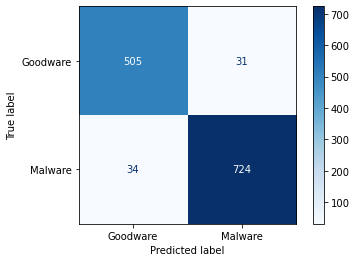

In [96]:
highest_columns = [
    'apistats_counts', 
    'regkeys_written_nested_keys',
    'pe_imports_msvcrt',
    'pe_entropy_analysis',
    'pe_imports_kernel32',
    'regkeys_deleted_nested_keys',
    'loaded_dlls_onehot'
]

#join
selected_columns = list(datasets.keys())
joined_df = join_dfs(dfs = [datasets[column] for column in selected_columns],
                     initialization = datasets['pe_imports_libraries']['label'])

#balance
proportion = None
joined_df_subset = create_balanced_subset(joined_df, proportion = proportion, shuffled=True)

#create
X, y = get_X_y(joined_df_subset, label='label')

#test feature importance
#fi_cols = list(get_feature_importances(X, y, model=RandomForestClassifier(), limit=200)[0])
#X = X[fi_cols]

#print proportions
print(y.value_counts())

#split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

#params
clf_params = {
        'n_estimators': 500,
        'max_depth': 50,
        'max_features' : 'log2',
        #'clf__min_samples_split' : Integer(2, 10),
        #'min_samples_leaf' : Integer(1, 5),
        'criterion' : 'entropy',
        #'clf__bootstrap' : Categorical([True, False]),
        'max_samples' :0.9,
        #'warm_start' : Categorical([True, False]),        
        #'ccp_alpha' : Real(1e-9, 1.0, 'log-uniform')
}

#train and predict
pipe = Pipeline(steps=[
    ('selector', SelectKBest(mutual_info_classif, k=min(500, len(joined_df.columns))-1)),
    ('preprocessor', ScalerSelector(scaler=MinMaxScaler())),
    ('clf', RandomForestClassifier(**clf_params))
])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)

#confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0,1])

#accuracy
print()
print('Accuracy :', round(accuracy_score(y_test, y_pred),4))

#report
print()
print(classification_report(y_test, y_pred, labels=[0,1]))

#plot cm
ConfusionMatrixDisplay(cm,  display_labels=['Goodware', 'Malware']).plot(values_format=".0f", cmap='Blues')

# Final model training :

In [17]:
joined_df = join_dfs(list(datasets.values()))

joined_df_ = clean_column_names(joined_df)

clf_params = {
        'n_estimators': 200,
        'learning_rate': 1,
        'min_child_weight': 0,
        'max_depth': 13, 
        'gamma': 1e-09,
        'subsample': 1,              
        'colsample_bytree': 1,      
        'lambda': 1e-09,
        'alpha': 1e-09
}

xgb_model = XGBClassifier(objective = 'binary:logistic', 
                          eval_metric = 'error', 
                          silent=1, 
                          tree_method='approx',
                          **clf_params)


pipe = Pipeline(steps=[
    ('selector', SelectKBest(chi2, k=689)),
    ('preprocessor', MinMaxScaler()),
    ('clf', xgb_model)
])


X, y = get_X_y(joined_df_)    
    
pipe.fit(X, y)

[23:09:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "silent" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




Pipeline(steps=[('selector',
                 SelectKBest(k=689,
                             score_func=<function chi2 at 0x00000191C53E6EE0>)),
                ('preprocessor', MinMaxScaler()),
                ('clf',
                 XGBClassifier(alpha=1e-09, base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='error',
                               gamma=1e-09, gpu_id=-1, importance_type='gain',
                               interaction_constraints='', lambda=1e-09,
                               learning_rate=1, max_delta_step=0, max_depth=13,
                               min_child_weight=0, missing=nan,
                               monotone_constraints='()', n_estimators=200,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=9.99999972e-10,
                               reg_lambda=9.9999997

In [18]:
#save model
model_path = 'trained-model/model.pkl'
pickle.dump(pipe, open(model_path, 'wb'))

In [19]:
#load and reuse model
model = pickle.load(open(model_path, 'rb'))
model.score(X,y)

0.9988404452690167

In [101]:
all_features = pickle.load(open('selected-features/prefixed/all_columns.pkl', 'rb'))

In [44]:
i = 809
print(y[i])
X_ = pd.DataFrame(X.iloc[i,:]).T
label = model.predict(X_)[0]
(label, model.predict_proba(X_)[0][label])

0


(0, 1.0)

In [52]:
def clean_column_names(df):
    '''replace the characters ( '[', ']', '<' ) with ( '_' ) in column names because XGBoost doesnt accept them'''
    df = df.copy()
    regex = re.compile(r"\[|\]|<", re.IGNORECASE)
    df.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in df.columns.values]
    return df


def main():
    
    dataset_path = os.getcwd() + os.sep + 'dataset/result.pkl.gz'
    model_path = os.getcwd() + os.sep + 'trained-model/model.pkl'
    
    #load dataset
    dataset = pd.read_pickle(dataset_path, compression='gzip')
    
    #clean column names for XGBoost
    X = clean_column_names(dataset)
    X = X.iloc[:1,:]
    
    #load model
    model = pickle.load(open(model_path, 'rb'))
    
    #predict class
    label = model.predict(X)[0]
    file_type = 'Malware' if label==1 else 'Goodware'
    message = 'Be careful, this file is dangerous!' if label==1 else 'The file is safe for download.'
    
    #get probability of predicted class
    prob = model.predict_proba(X)[0][label]
    
    #print result
    print(f'The file is determined to be {file_type} with {round(100*prob, 2)}%. \n\nConclusion: {message}')


main()

The file is determined to be Malware with 100.0%. 

Conclusion: Be careful, this file is dangerous!
